# Problema de Classificação
  Dataset: "Multiclass Diabetes Dataset

  https://www.kaggle.com/datasets/yasserhessein/multiclass-diabetes-dataset/data

  Características do Dataset
* Gender (Gênero): O sexo biológico do indivíduo. Geralmente codificado como: 0 = Feminino, 1 = Masculino. O gênero pode influenciar o risco de diabetes devido a diferenças hormonais e de estilo de vida.

* AGE (Idade): A idade do sujeito em anos. A idade é um fator de risco crítico para o aumento do risco de diabetes, especialmente após os 45 anos.

* Urea (Ureia): Uma medida da ureia (em mg/dL) no sangue. Níveis altos podem indicar problemas renais, que são complicações comuns do diabetes. Intervalo normal: ~7–20 mg/dL.

* Cr (Creatinine - Creatinina): Mede o nível de creatinina no sangue (em mg/dL). Também é um marcador de função renal. Níveis elevados de creatinina podem sugerir problemas renais, frequentemente ligados ao diabetes. Intervalo normal: ~0.6–1.3 mg/dL.

* HbA1c (Glycated Hemoglobin - Hemoglobina Glicada): Um indicador-chave do nível médio de glicose no sangue nos últimos 2-3 meses. Expresso em porcentagem. Normal: <5.7%, Pré-diabético: 5.7–6.4%, Diabético: ≥6.5%.

* Chol (Cholesterol - Colesterol): Colesterol total no sangue (em mg/dL). O colesterol alto é um fator de risco para doenças cardiovasculares, frequentemente observado em indivíduos diabéticos. Normal: <200 mg/dL.

* TG (Triglycerides - Triglicerídeos): Mede a quantidade de gordura no sangue (em mg/dL). Níveis altos estão associados à resistência à insulina e à síndrome metabólica. Normal: <150 mg/dL.

* HDL (High-Density Lipoprotein): O "bom" colesterol (em mg/dL). Níveis mais altos são melhores. Ajuda a remover o excesso de colesterol da corrente sanguínea. Ideal: >40 mg/dL (homens), >50 mg/dL (mulheres).

* LDL (Low-Density Lipoprotein): O "mau" colesterol (em mg/dL). Níveis altos contribuem para o acúmulo de placa nas artérias. Ótimo: <100 mg/dL.

* VLDL (Very Low-Density Lipoprotein): Outro tipo de "mau" colesterol (em mg/dL). Transporta triglicerídeos. Estimado frequentemente como TG/5. Níveis altos de VLDL estão associados a um risco aumentado de diabetes. Normal: 2–30 mg/dL.

* BMI (Body Mass Index - Índice de Massa Corporal): Uma medida de gordura corporal com base no peso e na altura (em kg/m²). A obesidade (IMC ≥30) é um fator de risco importante para o Diabetes Tipo 2. Abaixo do peso: <18.5, Normal: 18.5–24.9, Sobrepeso: 25–29.9, Obeso: ≥30.

* Class (Classe): Rótulo do alvo: indica o status de diabetes. Geralmente codificado como: 0 = Não-Diabético, 1 = Diabético, 2 = Previsão-Diabético. Este é o resultado que você está tentando prever ou classificar.

# Imports

In [ ]:
# bibliotecas padrão
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, kstest, normaltest
from scipy.stats import chi2_contingency

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, log_loss, roc_auc_score,
    average_precision_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from collections import defaultdict
from itertools import cycle

# Funções úteis

### verificar_normalidade

In [ ]:
def verificar_normalidade(data_series, feature_name, alpha=0.05):
    """
    Aplica os testes de Shapiro-Wilk e D'Agostino's K-squared a uma série de dados
    e imprime uma conclusão sobre sua normalidade.

    Args:
        data_series (pd.Series): A série de dados (coluna do DataFrame) a ser testada.
        feature_name (str): O nome da feature para impressão.
        alpha (float): O nível de significância para o teste.
    """
    print(f"--- Análise de Normalidade para a Feature: '{feature_name}' ---")

    # 1. Teste de Shapiro-Wilk
    stat_shapiro, p_shapiro = shapiro(data_series)
    print(f"\n1. Teste de Shapiro-Wilk:")
    print(f"   - Estatística do teste = {stat_shapiro:.4f}")
    print(f"   - P-valor = {p_shapiro:.4f}")
    if p_shapiro > alpha:
        print(f"   - Conclusão (alpha={alpha}): Não há evidência para rejeitar a normalidade (Normal).")
    else:
        print(f"   - Conclusão (alpha={alpha}): A hipótese de normalidade é rejeitada (Não Normal).")

    # 2. Teste de D'Agostino's K-squared
    stat_k2, p_k2 = normaltest(data_series)
    print(f"\n2. Teste de D'Agostino's K-squared:")
    print(f"   - Estatística do teste = {stat_k2:.4f}")
    print(f"   - P-valor = {p_k2:.4f}")
    if p_k2 > alpha:
        print(f"   - Conclusão (alpha={alpha}): Não há evidência para rejeitar a normalidade (Normal).")
    else:
        print(f"   - Conclusão (alpha={alpha}): A hipótese de normalidade é rejeitada (Não Normal).")

    print("-" * 50 + "\n")

### aplicar_transformacao_log

In [ ]:
def aplicar_transformacao_log(df, colunas):
    """
    Aplica a transformação logarítmica (log1p) a uma lista de colunas
    de um DataFrame e cria novas colunas com o sufixo '_log'.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        colunas (list): Uma lista de nomes de colunas para transformar.

    Returns:
        pd.DataFrame: O DataFrame com as novas colunas transformadas.
    """
    df_transformado = df.copy()
    #new_columns = []
    for col in colunas:
        # Verifica se a coluna existe no DataFrame
        if col in df_transformado.columns:
            df_transformado[col + '_log'] = np.log1p(df_transformado[col])
            #new_columns.append(col + '_log')
        else:
            print(f"Aviso: A coluna '{col}' não foi encontrada no DataFrame.")

    return df_transformado

### perform_cross_validation

In [ ]:
def perform_cross_validation(X_train, y_train, skf, model, average='weighted'):
    """
    Realiza validação cruzada estratificada com cálculo de múltiplas métricas.

    Para cada fold, treina o modelo fornecido com escalonamento de features,
    calcula predições e probabilidades, e retorna um dicionário com as métricas
    de desempenho tanto para o conjunto de treino quanto para o de validação.

    Parameters
    ----------
    X_train : pd.DataFrame or np.ndarray
        Features do conjunto de treinamento.
    y_train : pd.Series or np.ndarray
        Labels do conjunto de treinamento.
    skf : StratifiedKFold
        Objeto StratifiedKFold configurado.
    model : estimator object
        Instância do modelo de classificação a ser treinado.
    average : str, default='weighted'
        Tipo de média para métricas multiclasse (precision, recall, f1_score).

    Returns
    -------
    results : dict
        Dicionário contendo as listas de métricas calculadas para cada fold.
    """

    # Dicionário para armazenar os resultados, instanciado dentro da função
    results = defaultdict(lambda: defaultdict(list))

    n_splits = skf.get_n_splits()

    # Binarizador é 'fitado' uma única vez antes do loop para consistência
    lb = LabelBinarizer()
    lb.fit(y_train)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f"\n--- Processando Fold {fold}/{n_splits} ---")

        # Divisão dos dados do fold (usando indexação que funciona para pandas e numpy)
        if isinstance(X_train, pd.DataFrame):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        else:
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]

        if isinstance(y_train, pd.Series):
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        else:
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Escalonamento das features
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        # Treinamento do modelo (usa o objeto 'model' passado como argumento)
        model.fit(X_train_fold_scaled, y_train_fold)

        # Predições e Probabilidades
        datasets = {
            'train': (y_train_fold, X_train_fold_scaled),
            'validation': (y_val_fold, X_val_fold_scaled)
        }

        # Cálculo e Armazenamento das Métricas
        for name, (y_true, X_scaled) in datasets.items():
            y_pred = model.predict(X_scaled)
            y_proba = model.predict_proba(X_scaled)

            # Binarização usando o binarizador já 'fitado'
            y_true_bin = lb.transform(y_true)

            # Calculando as métricas
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average=average)
            recall = recall_score(y_true, y_pred, average=average)
            precision = precision_score(y_true, y_pred, average=average, zero_division=0)
            loss = (-1)*log_loss(y_true, y_proba)
            roc = roc_auc_score(y_true_bin, y_proba, multi_class='ovr', average='weighted')
            pr_auc = average_precision_score(y_true_bin, y_proba, average='micro')

            # Armazenando os resultados
            results[name]['accuracy'].append(acc)
            results[name]['f1_score'].append(f1)
            results[name]['recall'].append(recall)
            results[name]['precision'].append(precision)
            results[name]['log_loss'].append(loss) # Armazena o valor real do log_loss
            results[name]['roc_auc'].append(roc)
            results[name]['pr_auc'].append(pr_auc)

    print("\nValidação Cruzada concluída.")
    return results

# Carregando dados

In [ ]:
data_raw = pd.read_csv("data/Dataset of Diabetes.csv")
data_raw.head()

ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI CLASS  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N

In [ ]:
data = data_raw.drop(columns=['ID', 'No_Pation'])
data.head()

Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI CLASS
0      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0     N
1      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0     N
2      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0     N
3      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0     N
4      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0     N

# Tratamento de dados inicial

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  1000 non-null   object 
 1   AGE     1000 non-null   int64  
 2   Urea    1000 non-null   float64
 3   Cr      1000 non-null   int64  
 4   HbA1c   1000 non-null   float64
 5   Chol    1000 non-null   float64
 6   TG      1000 non-null   float64
 7   HDL     1000 non-null   float64
 8   LDL     1000 non-null   float64
 9   VLDL    1000 non-null   float64
 10  BMI     1000 non-null   float64
 11  CLASS   1000 non-null   object 
dtypes: float64(8), int64(2), object(2)
memory usage: 93.9+ KB


## Conversão de categóricas para numéricas

In [ ]:
data.drop(columns=['CLASS'])

Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI
0        F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0
1        M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0
2        F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0
3        F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0
4        M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0
..     ...  ...   ...  ..    ...   ...  ...  ...  ...   ...   ...
995      M   71  11.0  97    7.0   7.5  1.7  1.2  1.8   0.6  30.0
996      M   31   3.0  60   12.3   4.1  2.2  0.7  2.4  15.4  37.2
997      M   30   7.1  81    6.7   4.1  1.1  1.2  2.4   8.1  27.4
998      M   38   5.8  59    6.7   5.3  2.0  1.6  2.9  14.0  40.5
999      M   54   5.0  67    6.9   3.8  1.7  1.1  3.0   0.7  33.0

[1000 rows x 11 columns]

In [ ]:
num_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Variáveis numéricas: ", num_features)

cat_features = data.drop(columns=['CLASS']).select_dtypes(include=['object', 'category']).columns.tolist()
print("\nVariáveis categóricas: ", cat_features)

Variáveis numéricas:  ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']

Variáveis categóricas:  ['Gender']


### Feature 'Gender'

In [ ]:
data['Gender'].value_counts(normalize=False)

Gender
M    565
F    434
f      1
Name: count, dtype: int64

In [ ]:
mappig_gender = {'F': 0, 'M': 1, 'f': 0}
data['Gender'] = data['Gender'].map(mappig_gender)
data['Gender'].value_counts(normalize=False)

Gender
1    565
0    435
Name: count, dtype: int64

### Variável resposta 'CLASS'

In [ ]:
data['CLASS'].value_counts(normalize=False)

CLASS
Y     840
N     102
P      53
Y       4
N       1
Name: count, dtype: int64

In [ ]:
# Ajustando variável resposta

mapping_class = {'Y': 0, 'N': 1, 'P': 2, 'Y ': 0, 'N ':1}
data['CLASS'] = data['CLASS'].map(mapping_class)
data['CLASS'].value_counts(normalize=False)

CLASS
0    844
1    103
2     53
Name: count, dtype: int64

## Amostras duplicadas

In [ ]:
# Identificando presença de valores repetidos
data[data.duplicated()]

Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI  CLASS
2         0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1
3         0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      1
17        0   30   3.0  42    4.1   4.9  1.3  1.2  3.2   0.5  22.0      1
33        0   42   5.0  73    4.5   6.2  1.0  1.1  4.6   0.4  24.0      1
42        1   33   2.0  54    5.4   3.7  1.3  0.8  2.4   0.6  22.0      1
..      ...  ...   ...  ..    ...   ...  ...  ...  ...   ...   ...    ...
991       0   55   4.1  34   13.9   5.4  1.6  1.6  3.1   0.7  33.0      0
996       1   31   3.0  60   12.3   4.1  2.2  0.7  2.4  15.4  37.2      0
997       1   30   7.1  81    6.7   4.1  1.1  1.2  2.4   8.1  27.4      0
998       1   38   5.8  59    6.7   5.3  2.0  1.6  2.9  14.0  40.5      0
999       1   54   5.0  67    6.9   3.8  1.7  1.1  3.0   0.7  33.0      0

[174 rows x 12 columns]

In [ ]:
data_without_duplicates = data.drop_duplicates().reset_index(drop=True)
data_without_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  826 non-null    int64  
 1   AGE     826 non-null    int64  
 2   Urea    826 non-null    float64
 3   Cr      826 non-null    int64  
 4   HbA1c   826 non-null    float64
 5   Chol    826 non-null    float64
 6   TG      826 non-null    float64
 7   HDL     826 non-null    float64
 8   LDL     826 non-null    float64
 9   VLDL    826 non-null    float64
 10  BMI     826 non-null    float64
 11  CLASS   826 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 77.6 KB


# Análise Exploratória de Dados (EDA)

In [ ]:
# estatística descritiva das variáveis numéricas
data_without_duplicates[num_features].describe([.1, .25, .5, .75, .9, .95, .99]).T

count       mean        std   min     10%     25%     50%   75%  \
AGE    826.0  53.490315   8.808427  20.0  40.500  51.000  55.000  59.0   
Urea   826.0   5.184677   3.077831   0.5   2.800   3.615   4.600   5.7   
Cr     826.0  69.024213  59.557108   6.0  38.000  48.000  59.000  73.0   
HbA1c  826.0   8.326344   2.602589   0.9   5.000   6.500   8.100  10.2   
Chol   826.0   4.898208   1.328812   0.0   3.400   4.000   4.800   5.6   
TG     826.0   2.399370   1.456850   0.3   1.000   1.500   2.015   3.0   
HDL    826.0   1.211804   0.679610   0.2   0.775   0.900   1.100   1.3   
LDL    826.0   2.590061   1.132863   0.3   1.300   1.700   2.500   3.3   
VLDL   826.0   1.774576   3.517931   0.1   0.500   0.700   1.000   1.5   
BMI    826.0  29.459274   4.996676  19.0  22.750  26.000  30.000  33.0   

          90%      95%      99%     max  
AGE    61.000   65.750   75.000   79.00  
Urea    7.650   10.000   20.800   38.90  
Cr     91.500  112.750  339.750  800.00  
HbA1c  11.800   12.575   14.600   16.00  
Chol    6.500    7.200    9.275   10.30  
TG      4.200    5.100    7.150   13.80  
HDL     1.715    1.900    3.600    9.90  
LDL     4.000    4.300    5.600    9.90  
VLDL    2.000    4.775   19.150   35.00  
BMI    36.600   38.000   39.000   47.75

## Análise univariada

### Feature HbA1c

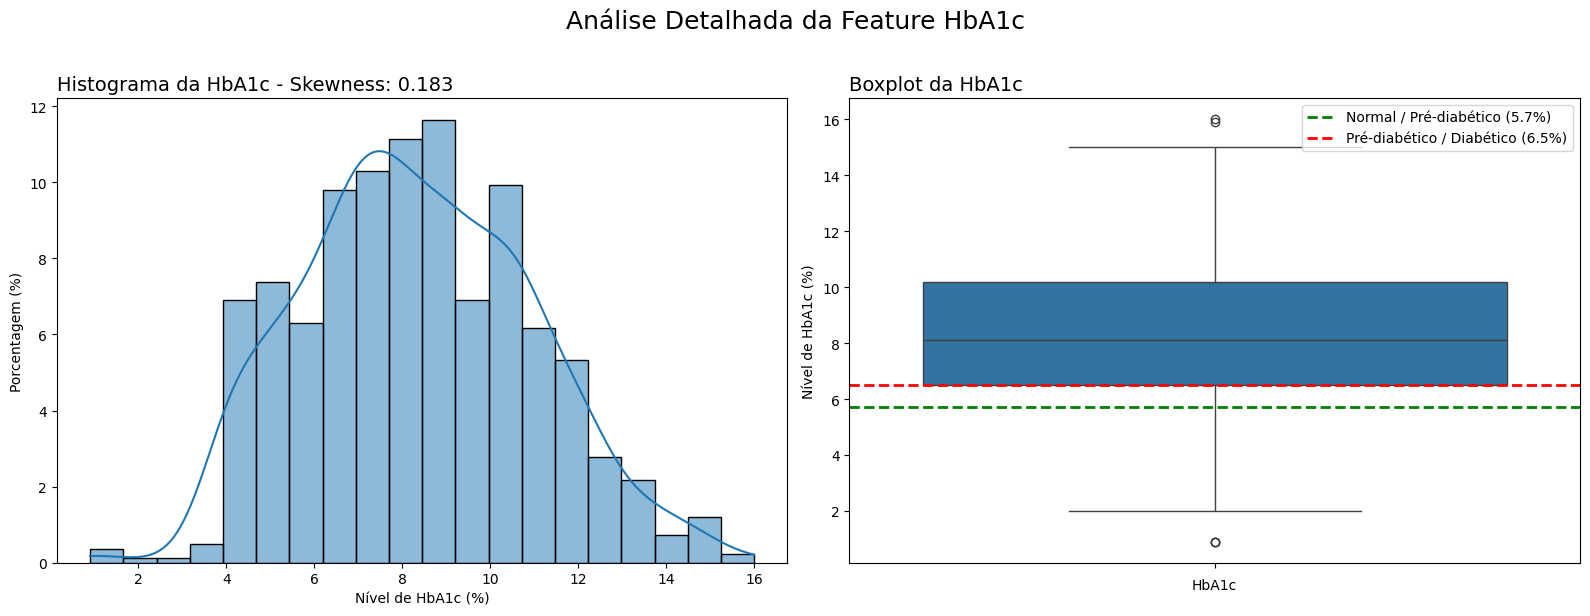

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['HbA1c'].skew()

# Histograma
sns.histplot(data_without_duplicates['HbA1c'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma da HbA1c - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de HbA1c (%)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['HbA1c'], ax=axes[1])
axes[1].set_title('Boxplot da HbA1c', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de HbA1c (%)')
axes[1].set_xlabel('HbA1c')

# Adicionando os limites para o HbA1c no boxplot
axes[1].axhline(y=5.7, color='green', linestyle='--', linewidth=2, label='Normal / Pré-diabético (5.7%)')
axes[1].axhline(y=6.5, color='red', linestyle='--', linewidth=2, label='Pré-diabético / Diabético (6.5%)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature HbA1c', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['HbA1c'], 'HbA1c')

--- Análise de Normalidade para a Feature: 'HbA1c' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.9909
   - P-valor = 0.0001
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 10.1089
   - P-valor = 0.0064
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature AGE

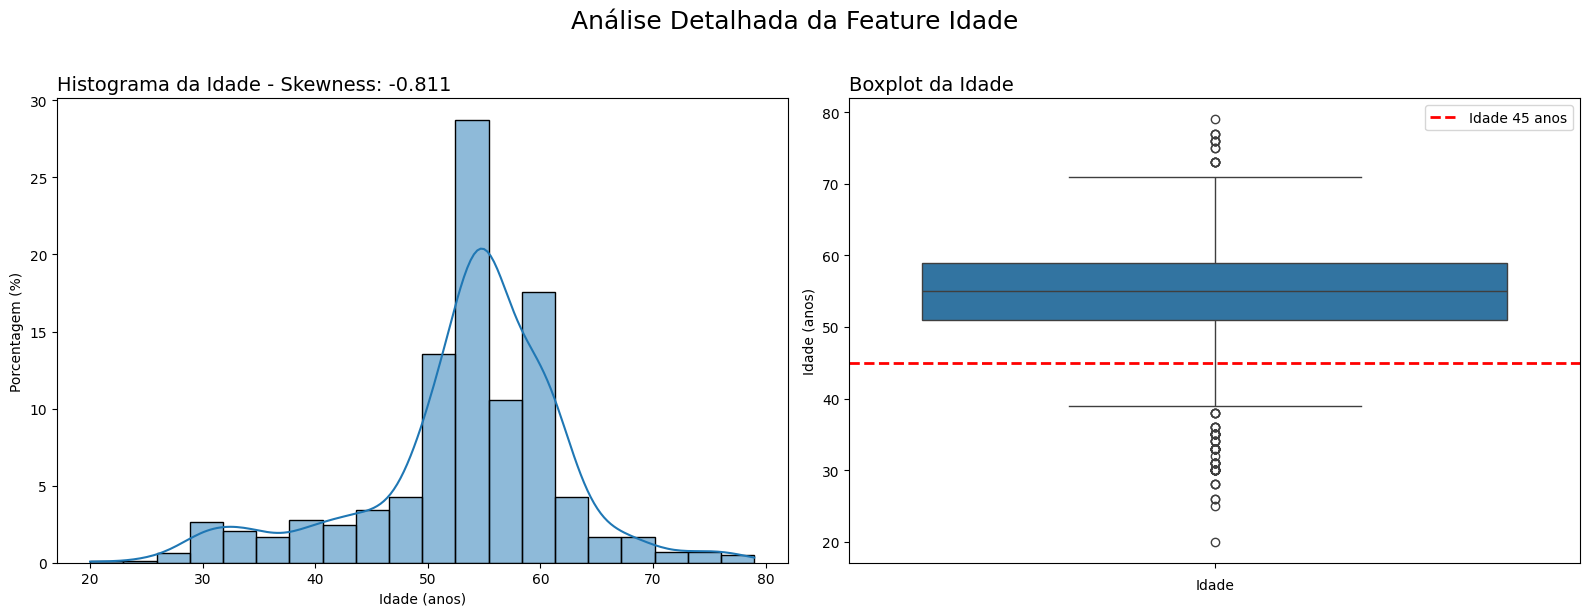

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['AGE'].skew()

# Histograma
sns.histplot(data_without_duplicates['AGE'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma da Idade - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Idade (anos)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['AGE'], ax=axes[1])
axes[1].set_title('Boxplot da Idade', fontsize=14, loc='left')
axes[1].set_ylabel('Idade (anos)')
axes[1].set_xlabel('Idade')

# Adicionando a linha de referência para idade de 45 anos no boxplot
axes[1].axhline(y=45, color='red', linestyle='--', linewidth=2, label='Idade 45 anos')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature Idade', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['AGE'], 'AGE')

--- Análise de Normalidade para a Feature: 'AGE' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.9231
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 100.0880
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feautre Urea

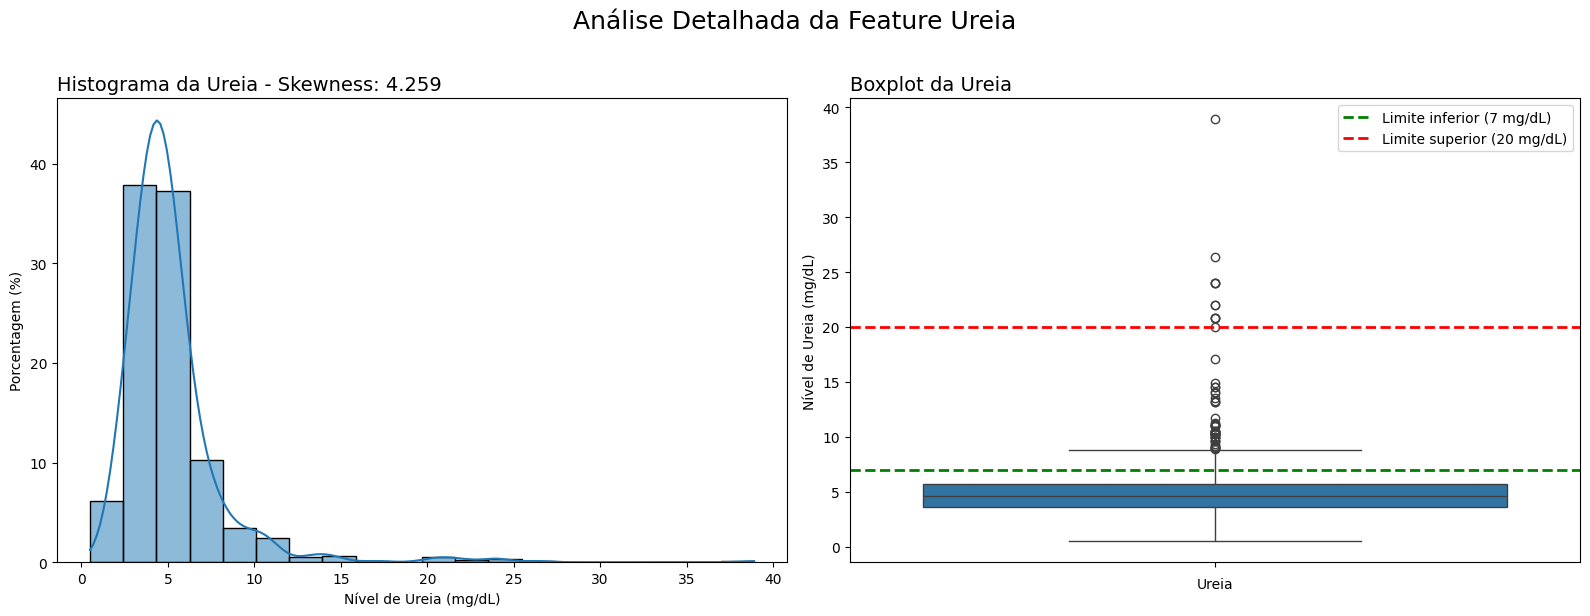

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['Urea'].skew()

# Histograma
sns.histplot(data_without_duplicates['Urea'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma da Ureia - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de Ureia (mg/dL)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['Urea'], ax=axes[1])
axes[1].set_title('Boxplot da Ureia', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de Ureia (mg/dL)')
axes[1].set_xlabel('Ureia')

# Adicionando os limites para a Ureia no boxplot
axes[1].axhline(y=7, color='green', linestyle='--', linewidth=2, label='Limite inferior (7 mg/dL)')
axes[1].axhline(y=20, color='red', linestyle='--', linewidth=2, label='Limite superior (20 mg/dL)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature Ureia', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['Urea'], 'Urea')

--- Análise de Normalidade para a Feature: 'Urea' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.6600
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 776.8278
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature Cr (creatinina)

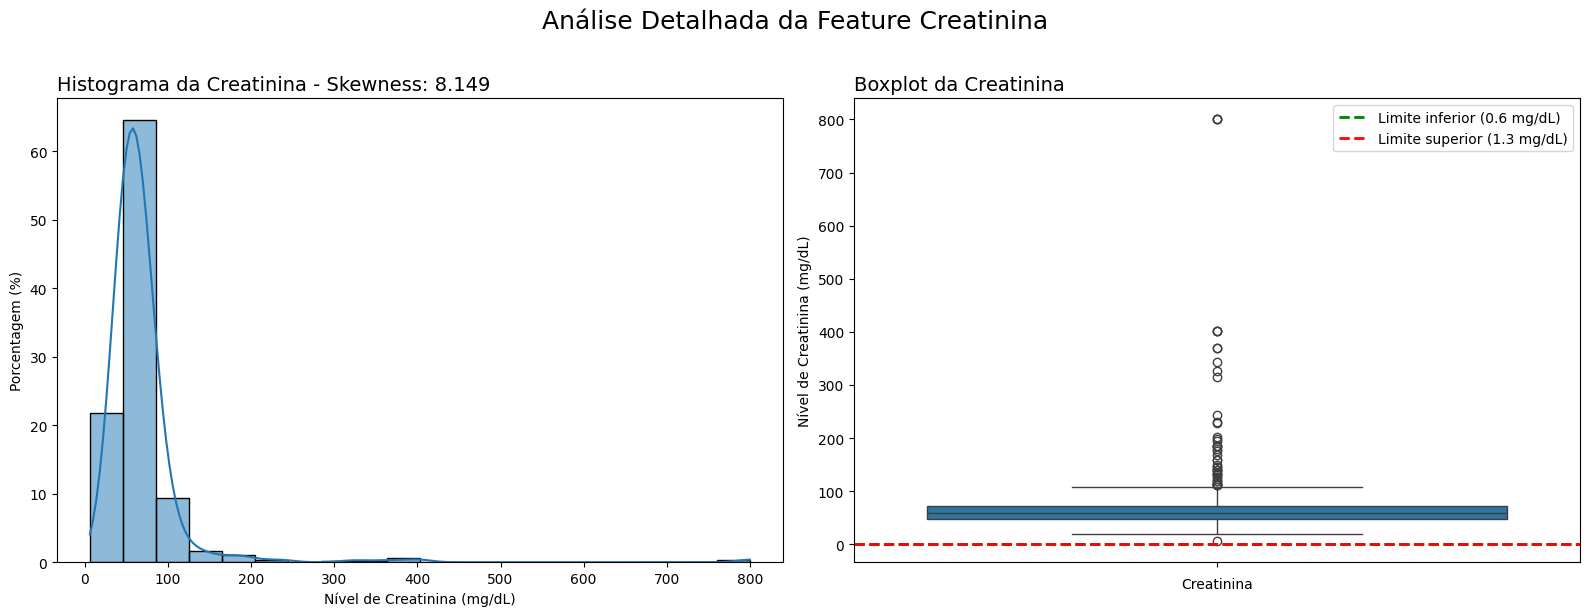

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['Cr'].skew()

# Histograma
sns.histplot(data_without_duplicates['Cr'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma da Creatinina - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de Creatinina (mg/dL)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['Cr'], ax=axes[1])
axes[1].set_title('Boxplot da Creatinina', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de Creatinina (mg/dL)')
axes[1].set_xlabel('Creatinina')

# Adicionando os limites para a Creatinina no boxplot
axes[1].axhline(y=0.6, color='green', linestyle='--', linewidth=2, label='Limite inferior (0.6 mg/dL)')
axes[1].axhline(y=1.3, color='red', linestyle='--', linewidth=2, label='Limite superior (1.3 mg/dL)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature Creatinina', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['Cr'], 'Cr')

--- Análise de Normalidade para a Feature: 'Cr' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.3959
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 1193.8153
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature Chol (cholesterol)

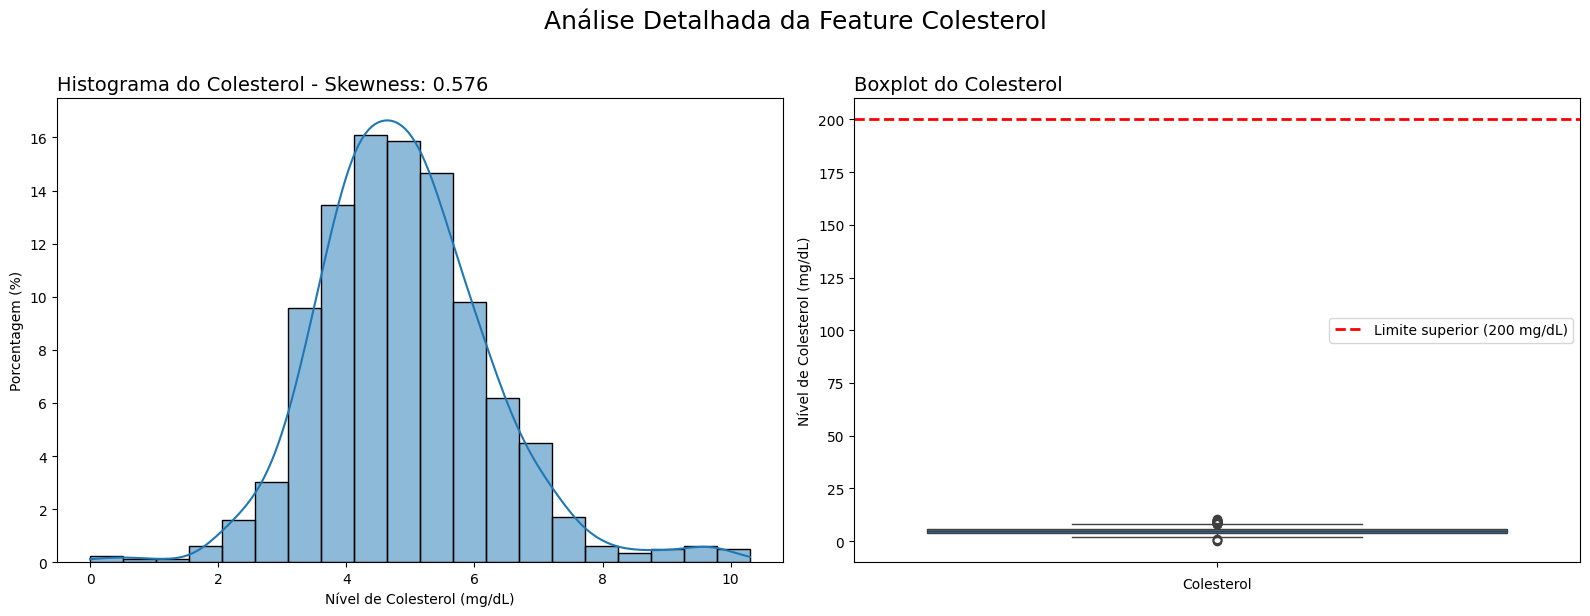

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['Chol'].skew()

# Histograma
sns.histplot(data_without_duplicates['Chol'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma do Colesterol - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de Colesterol (mg/dL)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['Chol'], ax=axes[1])
axes[1].set_title('Boxplot do Colesterol', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de Colesterol (mg/dL)')
axes[1].set_xlabel('Colesterol')

# Adicionando o limite para o Colesterol no boxplot
axes[1].axhline(y=200, color='red', linestyle='--', linewidth=2, label='Limite superior (200 mg/dL)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature Colesterol', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['Chol'], 'Chol')

--- Análise de Normalidade para a Feature: 'Chol' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.9726
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 74.4029
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature TG (triglicerídeos)

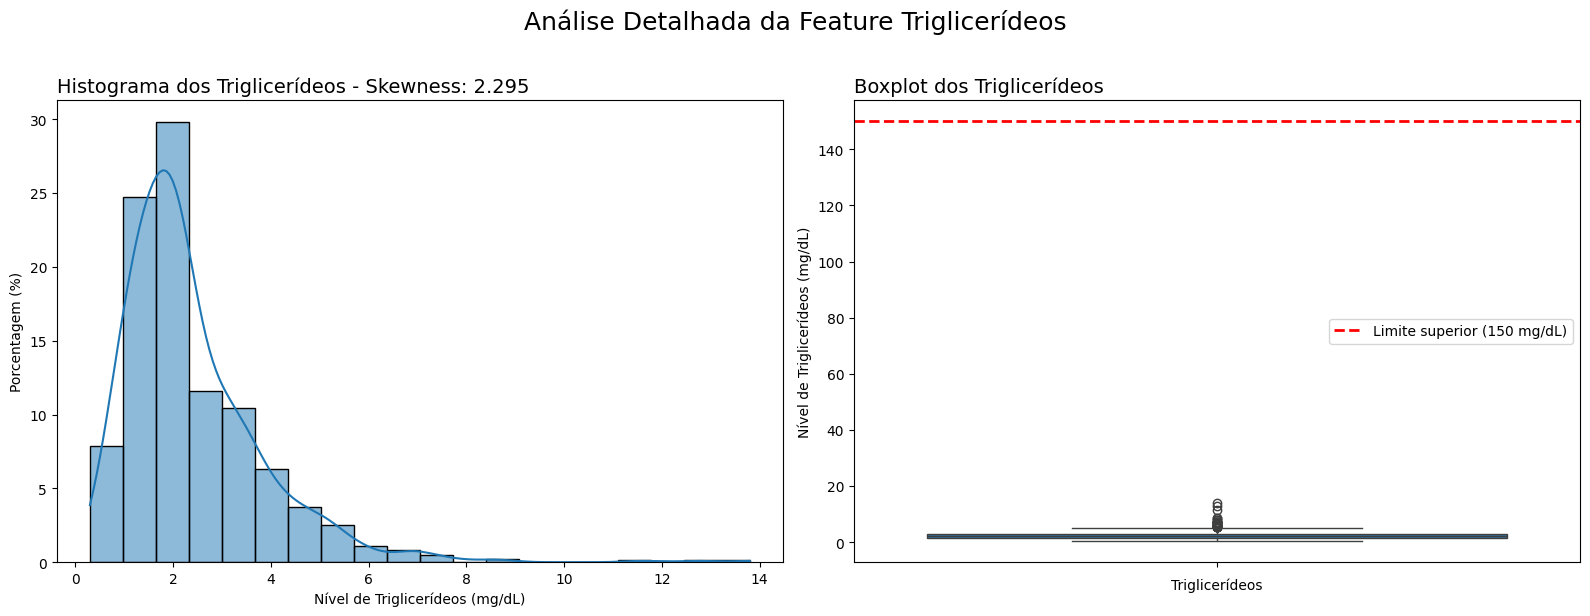

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['TG'].skew()

# Histograma
sns.histplot(data_without_duplicates['TG'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma dos Triglicerídeos - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de Triglicerídeos (mg/dL)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['TG'], ax=axes[1])
axes[1].set_title('Boxplot dos Triglicerídeos', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de Triglicerídeos (mg/dL)')
axes[1].set_xlabel('Triglicerídeos')

# Adicionando o limite para os Triglicerídeos no boxplot
axes[1].axhline(y=150, color='red', linestyle='--', linewidth=2, label='Limite superior (150 mg/dL)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature Triglicerídeos', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['TG'], 'TG')

--- Análise de Normalidade para a Feature: 'TG' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.8325
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 448.0801
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature HDL

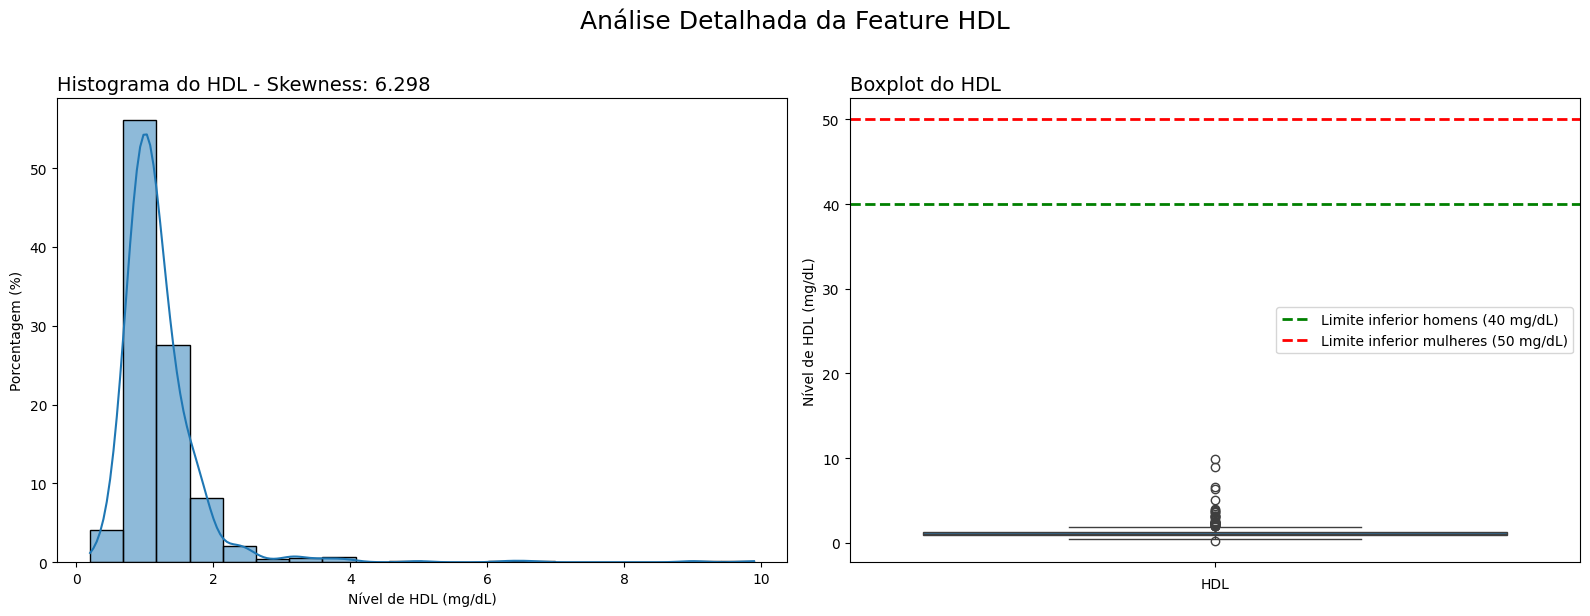

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['HDL'].skew()

# Histograma
sns.histplot(data_without_duplicates['HDL'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma do HDL - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de HDL (mg/dL)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['HDL'], ax=axes[1])
axes[1].set_title('Boxplot do HDL', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de HDL (mg/dL)')
axes[1].set_xlabel('HDL')

# Adicionando os limites para o HDL no boxplot
axes[1].axhline(y=40, color='green', linestyle='--', linewidth=2, label='Limite inferior homens (40 mg/dL)')
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Limite inferior mulheres (50 mg/dL)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature HDL', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['HDL'], 'HDL')

--- Análise de Normalidade para a Feature: 'HDL' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.5676
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 1028.6222
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature LDL (low-density lipoprotein)

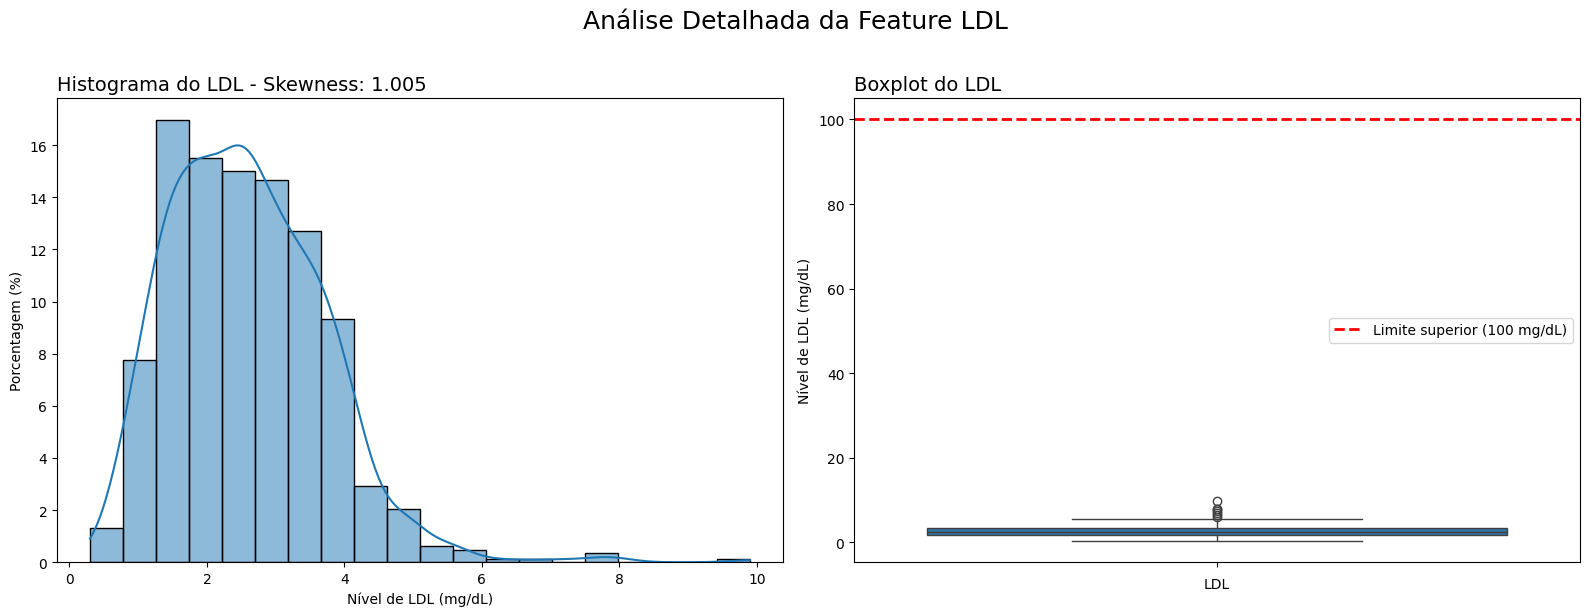

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['LDL'].skew()

# Histograma
sns.histplot(data_without_duplicates['LDL'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma do LDL - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de LDL (mg/dL)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['LDL'], ax=axes[1])
axes[1].set_title('Boxplot do LDL', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de LDL (mg/dL)')
axes[1].set_xlabel('LDL')

# Adicionando o limite para o LDL no boxplot
axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, label='Limite superior (100 mg/dL)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature LDL', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['LDL'], 'LDL')

--- Análise de Normalidade para a Feature: 'LDL' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.9499
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 163.9055
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature VLDL (Very-low-density lipoprotein)

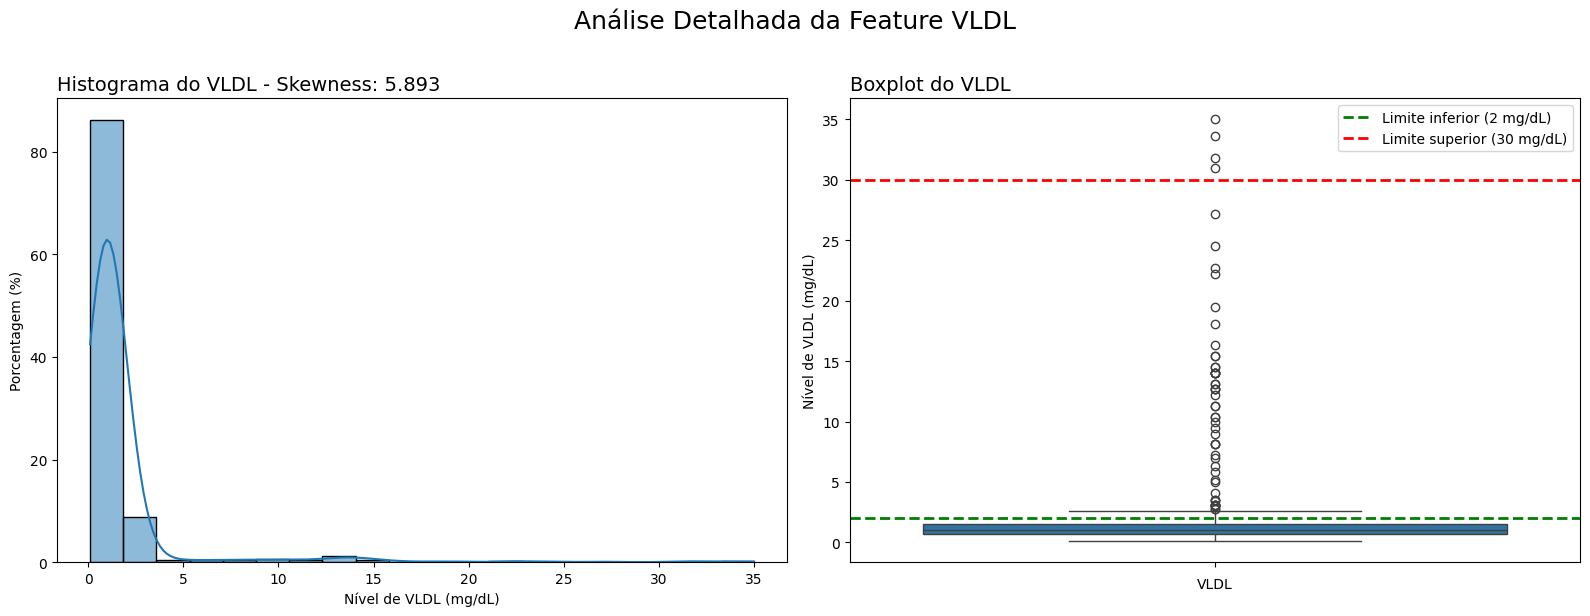

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['VLDL'].skew()

# Histograma
sns.histplot(data_without_duplicates['VLDL'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma do VLDL - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('Nível de VLDL (mg/dL)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['VLDL'], ax=axes[1])
axes[1].set_title('Boxplot do VLDL', fontsize=14, loc='left')
axes[1].set_ylabel('Nível de VLDL (mg/dL)')
axes[1].set_xlabel('VLDL')

# Adicionando os limites para o VLDL no boxplot
axes[1].axhline(y=2, color='green', linestyle='--', linewidth=2, label='Limite inferior (2 mg/dL)')
axes[1].axhline(y=30, color='red', linestyle='--', linewidth=2, label='Limite superior (30 mg/dL)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature VLDL', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['VLDL'], 'VLDL')

--- Análise de Normalidade para a Feature: 'VLDL' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.3260
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 958.1405
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature BMI (Body Mass Index)

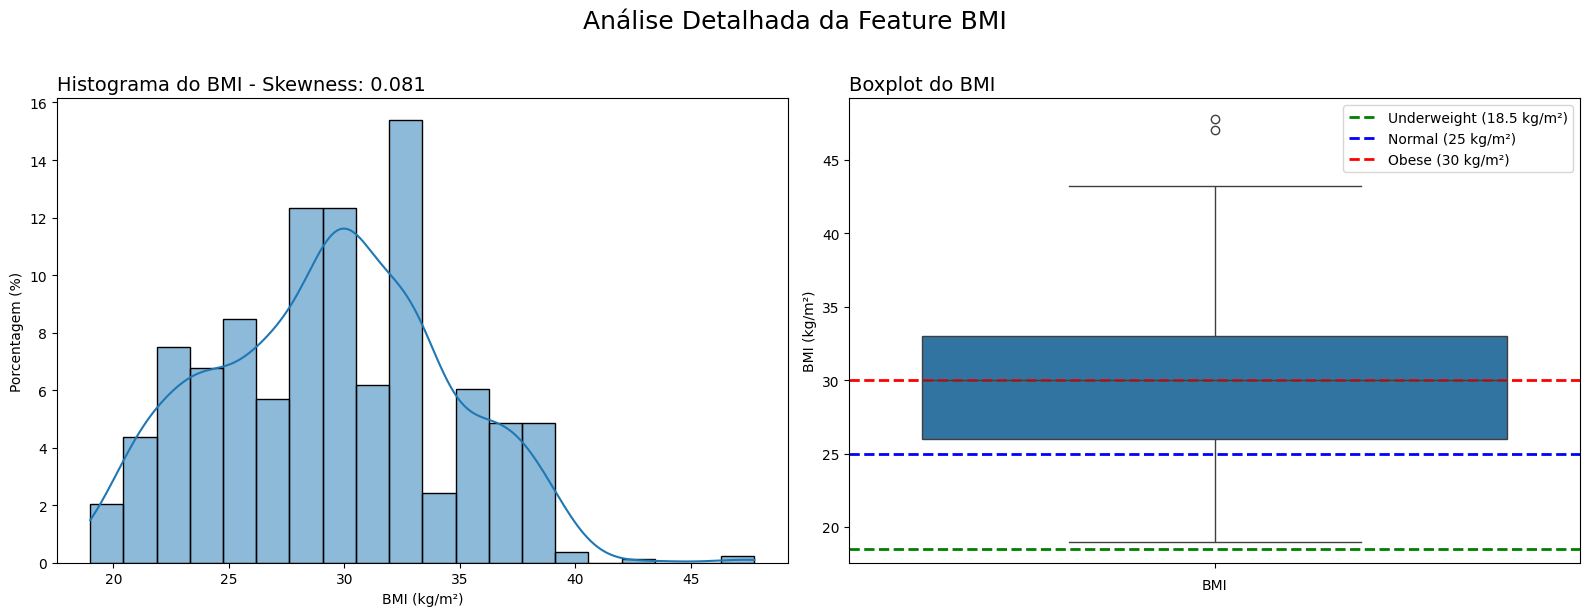

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculando a skewness
skewness = data_without_duplicates['BMI'].skew()

# Histograma
sns.histplot(data_without_duplicates['BMI'], kde=True, ax=axes[0], bins=20, stat='percent')
axes[0].set_title(f'Histograma do BMI - Skewness: {skewness:.3f}', fontsize=14, loc='left')
axes[0].set_xlabel('BMI (kg/m²)')
axes[0].set_ylabel('Porcentagem (%)')

# Boxplot
sns.boxplot(y=data_without_duplicates['BMI'], ax=axes[1])
axes[1].set_title('Boxplot do BMI', fontsize=14, loc='left')
axes[1].set_ylabel('BMI (kg/m²)')
axes[1].set_xlabel('BMI')

# Adicionando os limites para o BMI no boxplot
axes[1].axhline(y=18.5, color='green', linestyle='--', linewidth=2, label='Underweight (18.5 kg/m²)')
axes[1].axhline(y=25, color='blue', linestyle='--', linewidth=2, label='Normal (25 kg/m²)')
axes[1].axhline(y=30, color='red', linestyle='--', linewidth=2, label='Obese (30 kg/m²)')
axes[1].legend()

plt.suptitle('Análise Detalhada da Feature BMI', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Análise da normalidade da feature

verificar_normalidade(data_without_duplicates['BMI'], 'BMI')

--- Análise de Normalidade para a Feature: 'BMI' ---

1. Teste de Shapiro-Wilk:
   - Estatística do teste = 0.9832
   - P-valor = 0.0000
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).

2. Teste de D'Agostino's K-squared:
   - Estatística do teste = 10.7676
   - P-valor = 0.0046
   - Conclusão (alpha=0.05): A hipótese de normalidade é rejeitada (Não Normal).
--------------------------------------------------



### Feature Gender

In [ ]:
class_map = {0: 'Female', 1: 'Male'}

df = data_without_duplicates['Gender'].map(class_map)
df.rename('gender_label', inplace=True)
order_by_label = df.value_counts().index

class_counts = df.value_counts()

class_percentages = df.value_counts(normalize=True) * 100
print(class_percentages)

gender_label
Male      56.053269
Female    43.946731
Name: proportion, dtype: float64


In [ ]:
pd.DataFrame(df)['gender_label']

0      Female
1        Male
2        Male
3      Female
4      Female
        ...  
821    Female
822      Male
823      Male
824      Male
825      Male
Name: gender_label, Length: 826, dtype: object

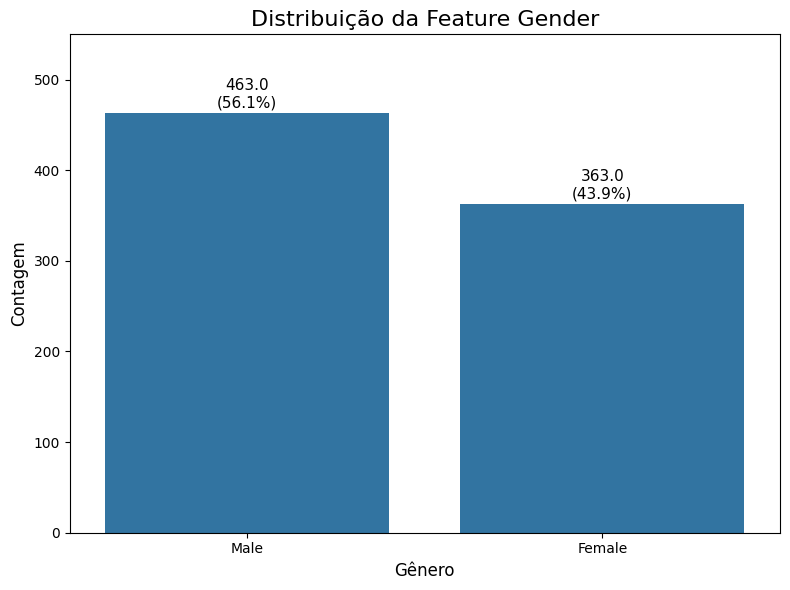

In [ ]:
# Visualização da distribuição da feature
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='gender_label', data=pd.DataFrame(df), order=order_by_label)

plt.title('Distribuição da Feature Gender', fontsize=16)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.ylim(0, 550)

# adicionando rotulos
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            f'{height}\n({height/len(data_without_duplicates)*100:.1f}%)',
            ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

### Análise da variável resposta

In [ ]:
class_map = {0: 'Diabético', 1: 'Não-Diabético', 2: 'Pré-Diabético'}
data_without_duplicates['CLASS_label'] = data_without_duplicates['CLASS'].map(class_map)

order_by_label = data_without_duplicates['CLASS_label'].value_counts().index
class_counts = data_without_duplicates['CLASS'].value_counts()

class_percentages = data_without_duplicates['CLASS'].value_counts(normalize=True) * 100
print(class_percentages)

CLASS
0    83.535109
1    11.622276
2     4.842615
Name: proportion, dtype: float64


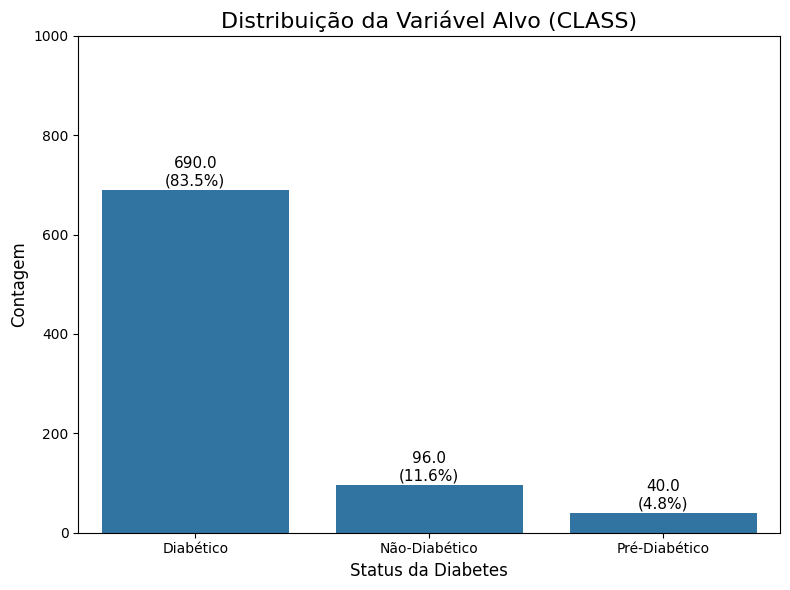

In [ ]:
# Visualização da distribuição da variável alvo
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CLASS_label', data=data_without_duplicates, order=order_by_label)

plt.title('Distribuição da Variável Alvo (CLASS)', fontsize=16)
plt.xlabel('Status da Diabetes', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.ylim(0, 1000)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            f'{height}\n({height/len(data_without_duplicates)*100:.1f}%)',
            ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()

## Análise multivariada

### Matriz de correlação

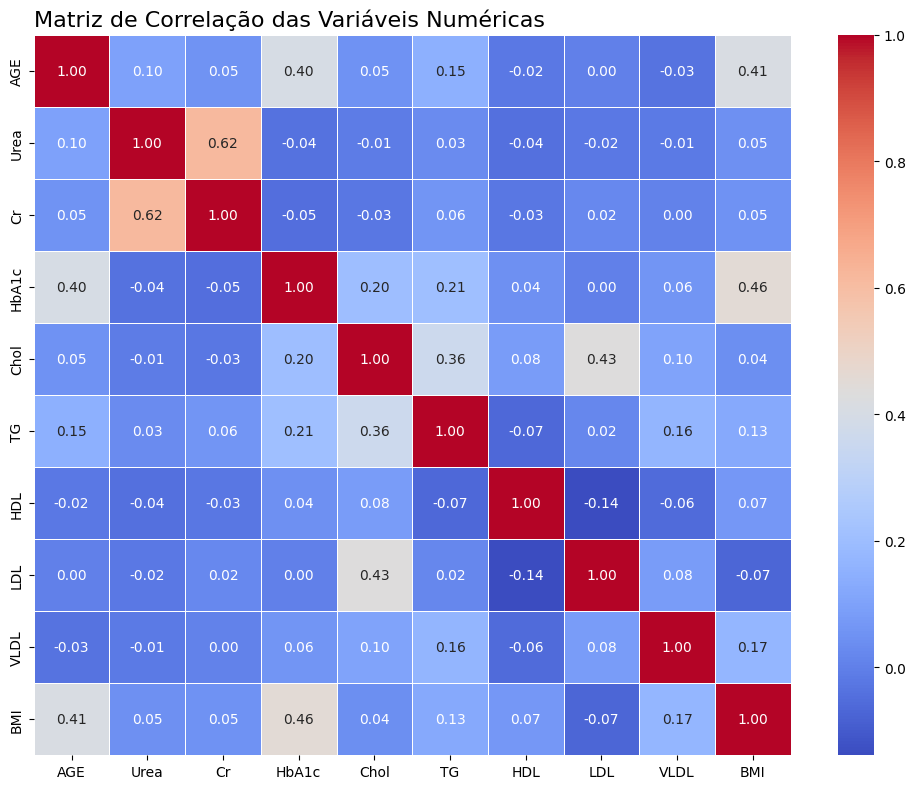

In [ ]:
correlation_matrix = data_without_duplicates[num_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Exibe os valores de correlação nas células
    cmap='coolwarm',     # Esquema de cores (azul para negativo, vermelho para positivo)
    fmt='.2f',           # Formata os números para duas casas decimais
    linewidths=.5        # Adiciona linhas finas entre as células
)

plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16, loc='left')

plt.tight_layout()
plt.show()

### Análise das features por classe da variável alvo

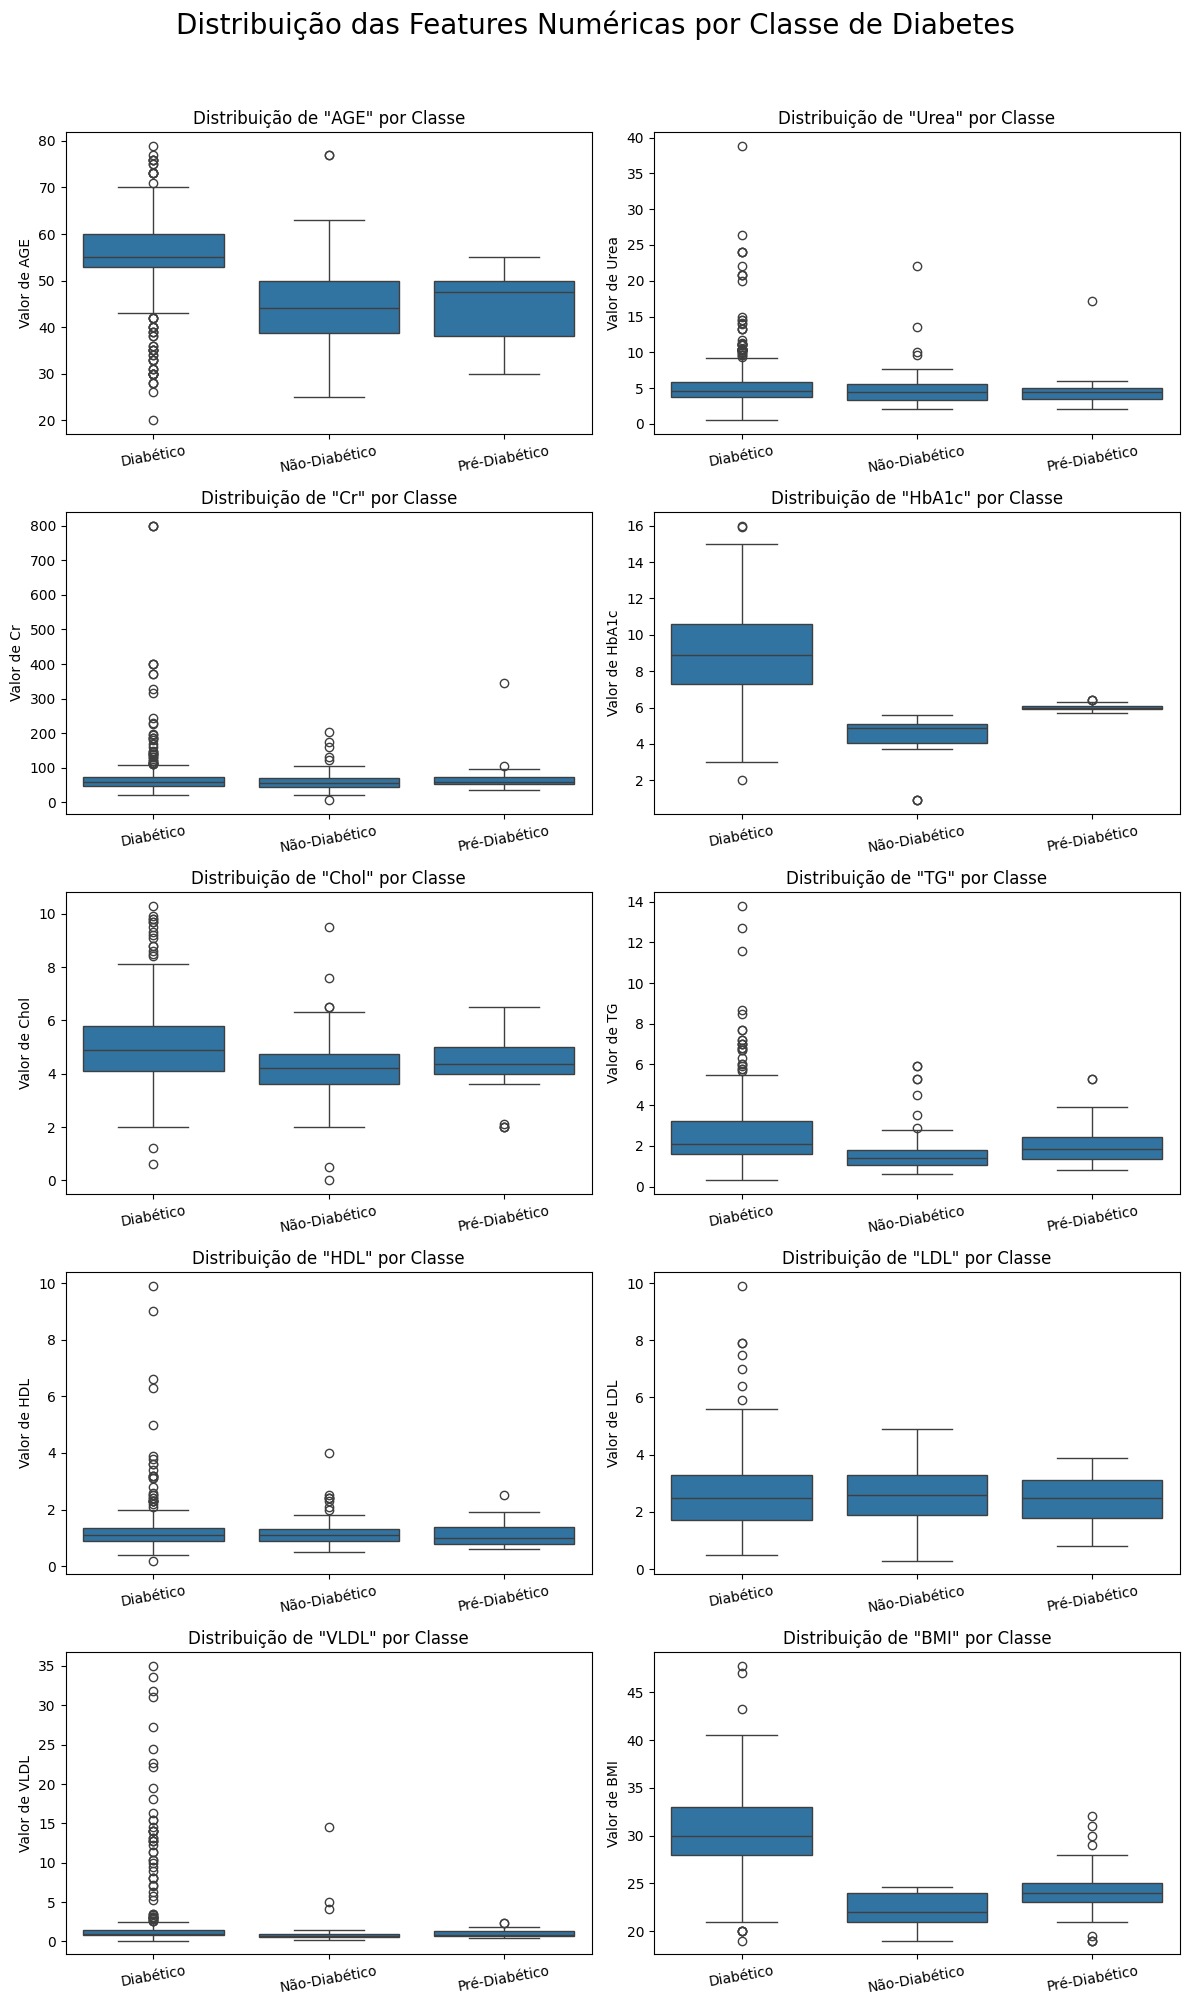

In [ ]:
class_order = data_without_duplicates['CLASS_label'].value_counts().index

nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 20))

# Achatar o array de eixos para facilitar a iteração
axes = axes.flatten()

# Iterando sobre as features e os eixos simultaneamente
for i, col in enumerate(num_features):
    ax = axes[i] # Seleciona o eixo atual
    sns.boxplot(
        x='CLASS_label',
        y=col,
        data=data_without_duplicates,
        order=class_order,
        ax=ax # Especifica em qual eixo o gráfico deve ser desenhado
    )
    ax.set_title(f'Distribuição de "{col}" por Classe', fontsize=12)
    ax.set_xlabel('') # Remove o rótulo do eixo X para limpar a visualização
    ax.set_ylabel(f'Valor de {col}', fontsize=10)
    ax.tick_params(axis='x', rotation=10)

# Ocultando os eixos extras que não foram utilizados
for i in range(len(num_features), len(axes)):
    axes[i].axis('off')

# Adicionando um título geral para toda a figura
fig.suptitle('Distribuição das Features Numéricas por Classe de Diabetes', fontsize=20, y=1.0)

# Ajustando o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Gender x CLASS

In [ ]:
data_without_duplicates['Gender_label'] = data_without_duplicates['Gender'].map({0: 'Female', 1: 'Male'})

# Criando a tabela de contingência
contingency_table = pd.crosstab(data_without_duplicates['Gender_label'], data_without_duplicates['CLASS_label'])

print("Tabela de Contingência: Gender vs. Class\n")
print(contingency_table)

Tabela de Contingência: Gender vs. Class

CLASS_label   Diabético  Não-Diabético  Pré-Diabético
Gender_label                                         
Female              292             58             13
Male                398             38             27



Tabela de Contingência (Percentual por Gênero):

CLASS_label   Diabético  Não-Diabético  Pré-Diabético
Gender_label                                         
Female        80.440771      15.977961       3.581267
Male          85.961123       8.207343       5.831533


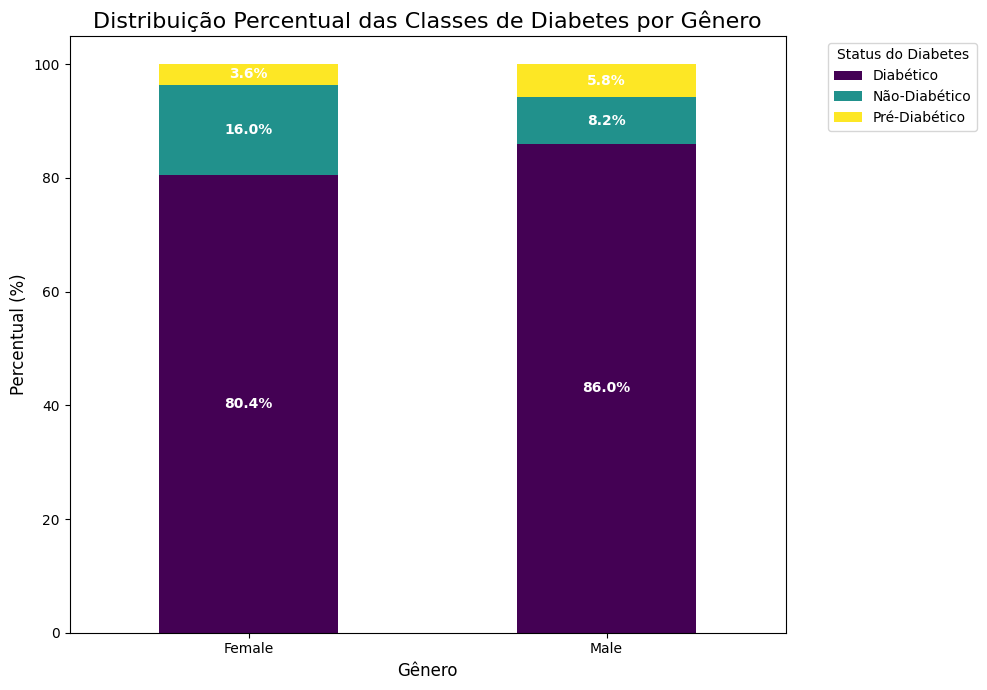

In [ ]:
contingency_table_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nTabela de Contingência (Percentual por Gênero):\n")
print(contingency_table_pct)

# Criando o gráfico de barras empilhadas 100%
ax = contingency_table_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 7),
    colormap='viridis'
)

plt.title('Distribuição Percentual das Classes de Diabetes por Gênero', fontsize=16)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Status do Diabetes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adicionando os rótulos de porcentagem no gráfico
for c in ax.containers:
    # A formatação pode ser ajustada para melhor visualização
    labels = [f'{w:.1f}%' if w > 0 else '' for w in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', color='white', weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\n--- Teste Qui-quadrado de Independência ---\n")
print(f"Estatística Qui-quadrado: {chi2:.4f}")
print(f"P-valor: {p_value:.4f}")
print(f"Graus de Liberdade (dof): {dof}")

alpha = 0.05
if p_value <= alpha:
    print(f"\nConclusão (alpha={alpha}): Rejeitamos a hipótese nula.")
    print("Há uma associação estatisticamente significativa entre Gênero e Classe de Diabetes.")
else:
    print(f"\nConclusão (alpha={alpha}): Falhamos em rejeitar a hipótese nula.")
    print("Não há evidência de uma associação estatisticamente significativa entre Gênero e Classe de Diabetes.")


--- Teste Qui-quadrado de Independência ---

Estatística Qui-quadrado: 13.4412
P-valor: 0.0012
Graus de Liberdade (dof): 2

Conclusão (alpha=0.05): Rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre Gênero e Classe de Diabetes.


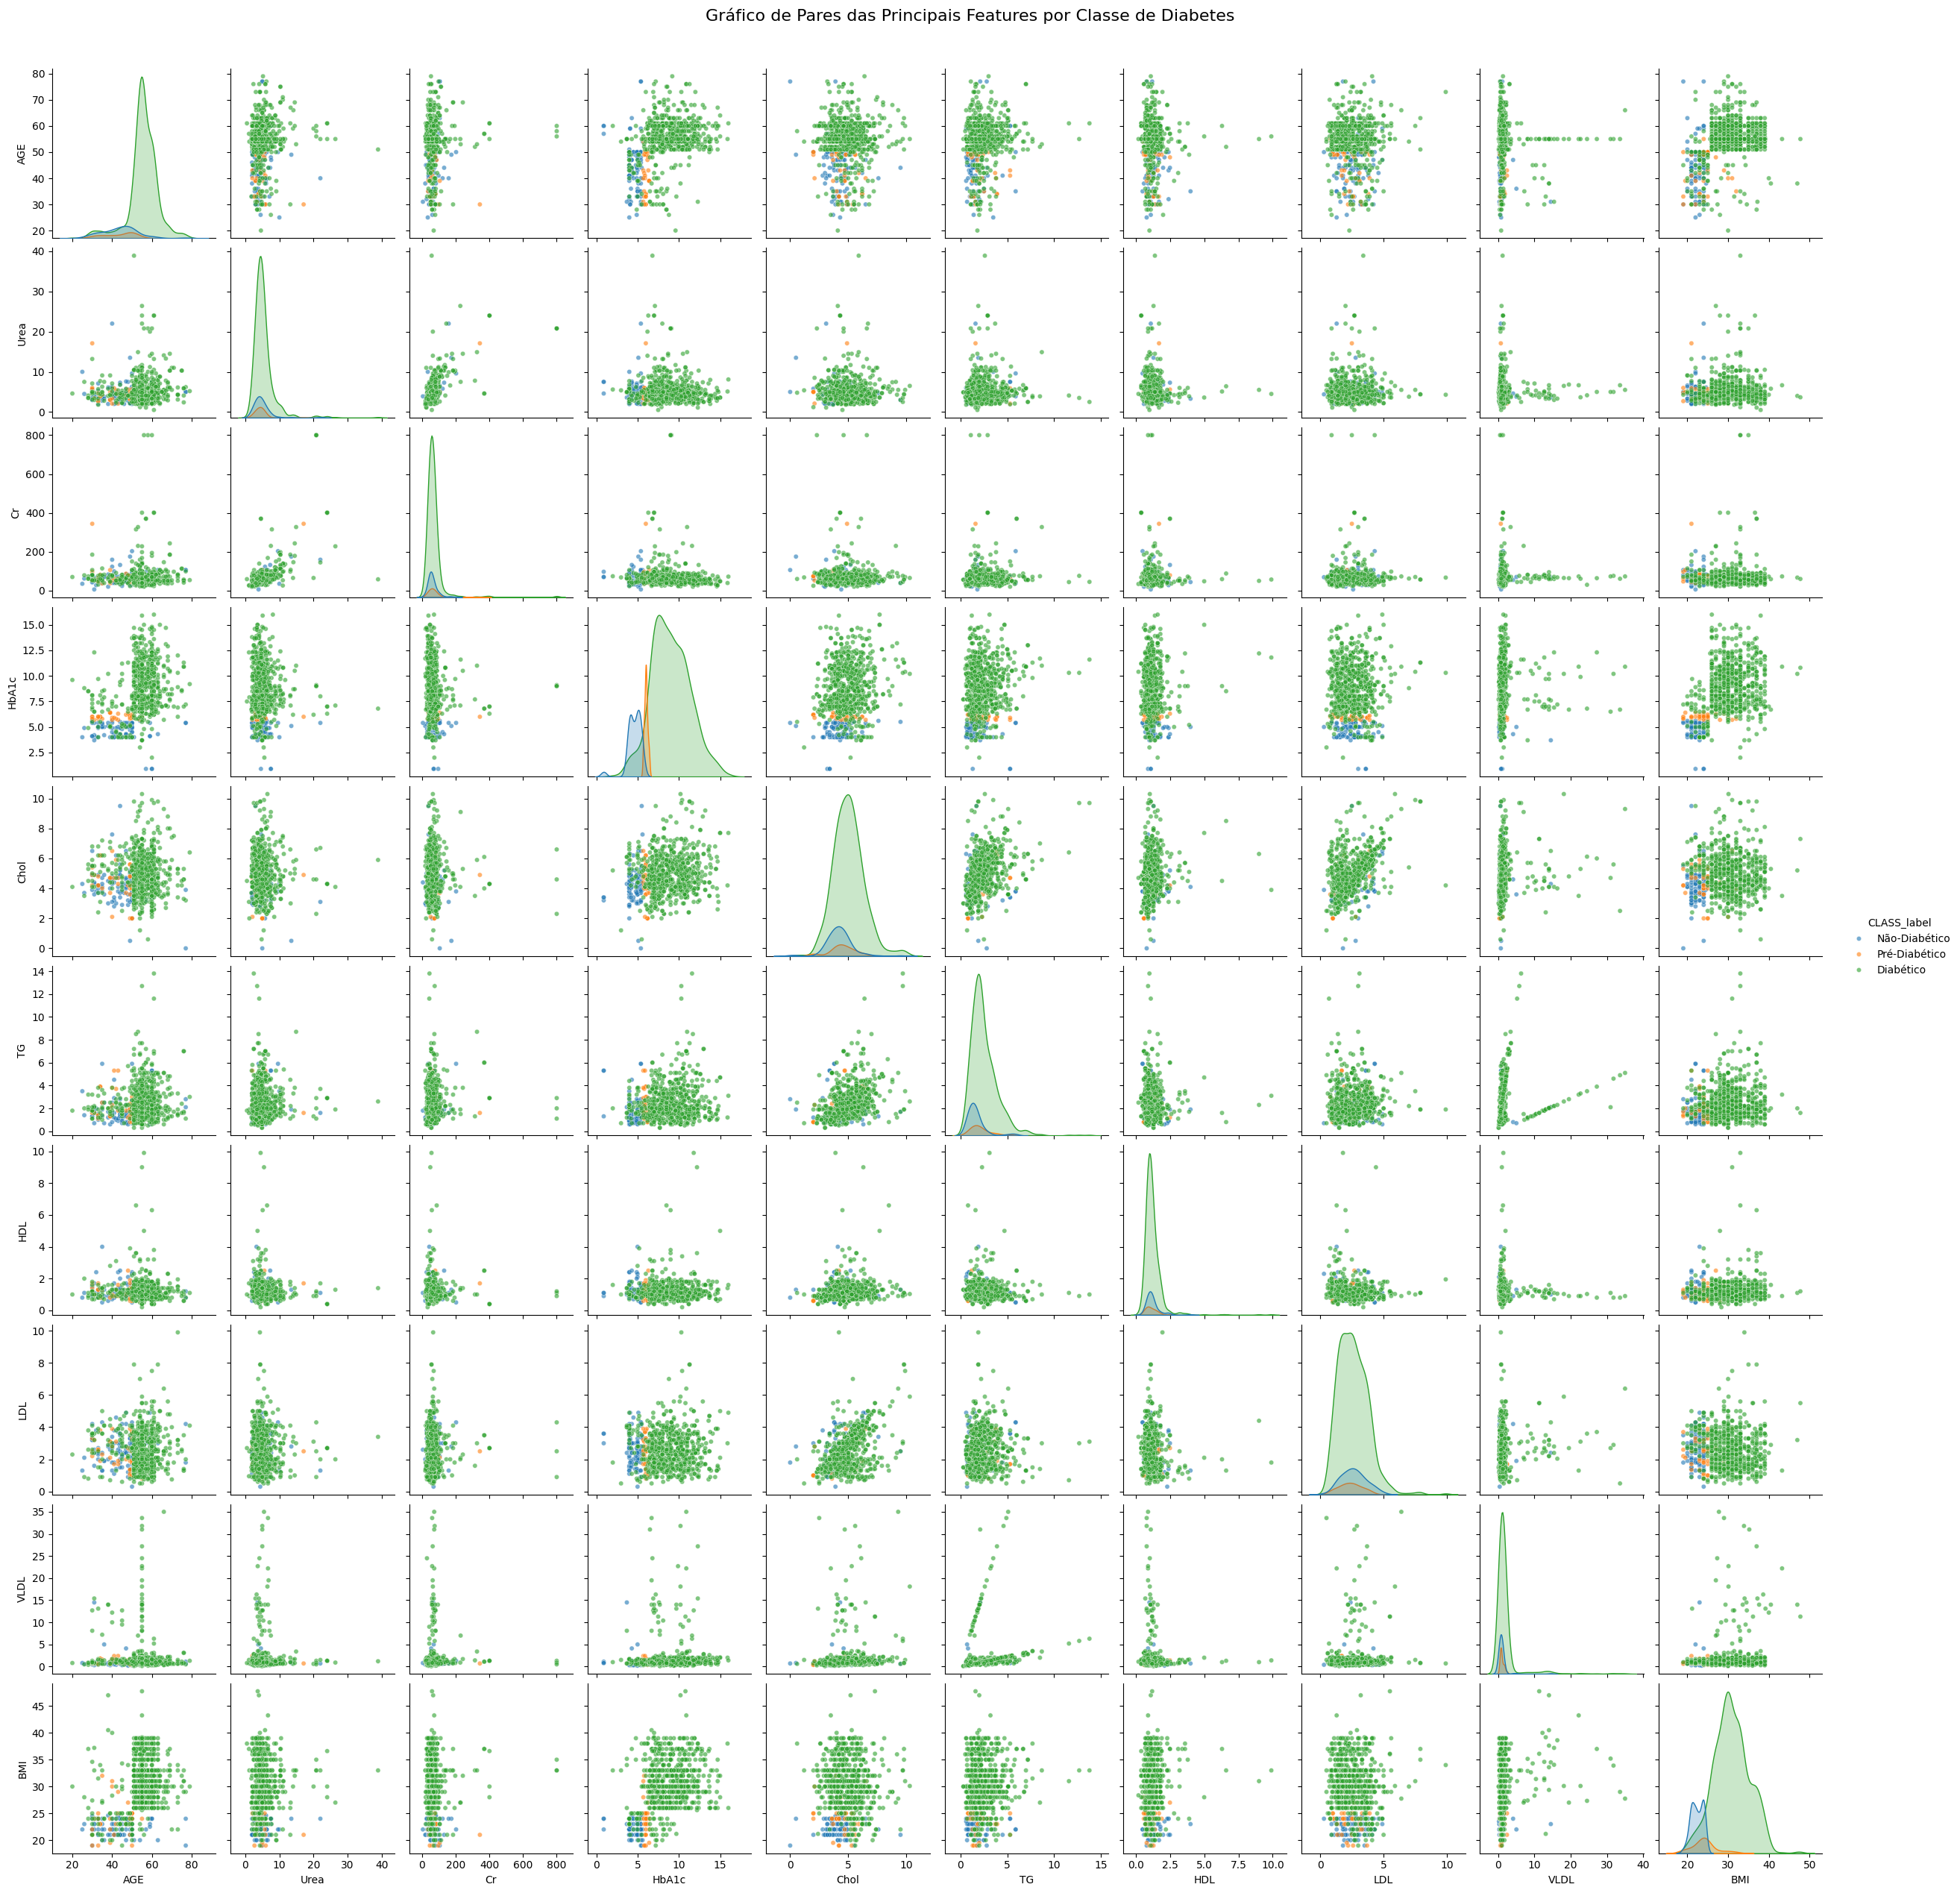

In [ ]:
features_for_pairplot = num_features

# Criando o pair plot
# diag_kind='kde' mostra a densidade da distribuição na diagonal
g = sns.pairplot(
    data=data_without_duplicates,
    vars=features_for_pairplot,
    hue='CLASS_label',
    #palette='viridis', # Esquema de cores
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 20} # Ajusta a transparência e o tamanho dos pontos
)

# Adicionando um título geral
g.fig.suptitle('Gráfico de Pares das Principais Features por Classe de Diabetes', y=1.02, fontsize=16)

plt.show()

# Pré-processamento

## Transformação logarítmica

In [ ]:
skewness = data_without_duplicates[num_features].skew()

# Selecionando colunas com skewness >= 1 ou <= -1
high_skew_columns = skewness[(skewness >= 1) | (skewness <= -1)]

# Nomes das colunas com alta skewness
skew_column_names = high_skew_columns.index.tolist()

df_log = aplicar_transformacao_log(data_without_duplicates, skew_column_names)

display(df_log[[col for col in df_log.columns.tolist() if col.endswith("_log")]].head())

Urea_log    Cr_log    TG_log   HDL_log   LDL_log  VLDL_log
0  1.740466  3.850148  0.641854  1.223775  0.875469  0.405465
1  1.704748  4.143135  0.875469  0.741937  1.131402  0.470004
2  2.091864  3.850148  0.693147  0.587787  1.098612  0.336472
3  1.193922  3.218876  0.693147  0.693147  0.916291  0.336472
4  1.098612  3.931826  0.832909  0.641854  1.131402  0.470004

### Visualização da transformação

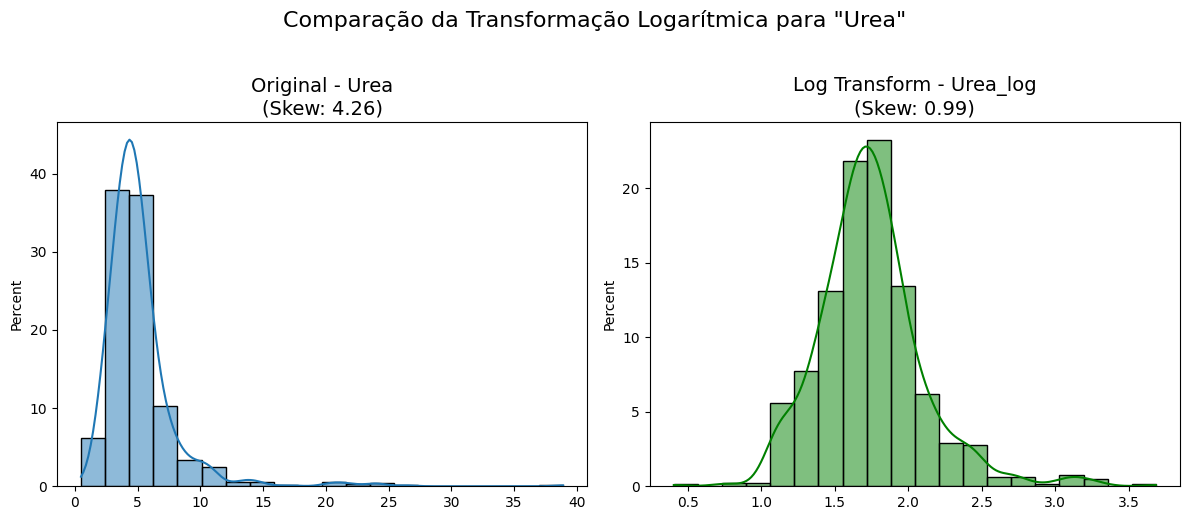

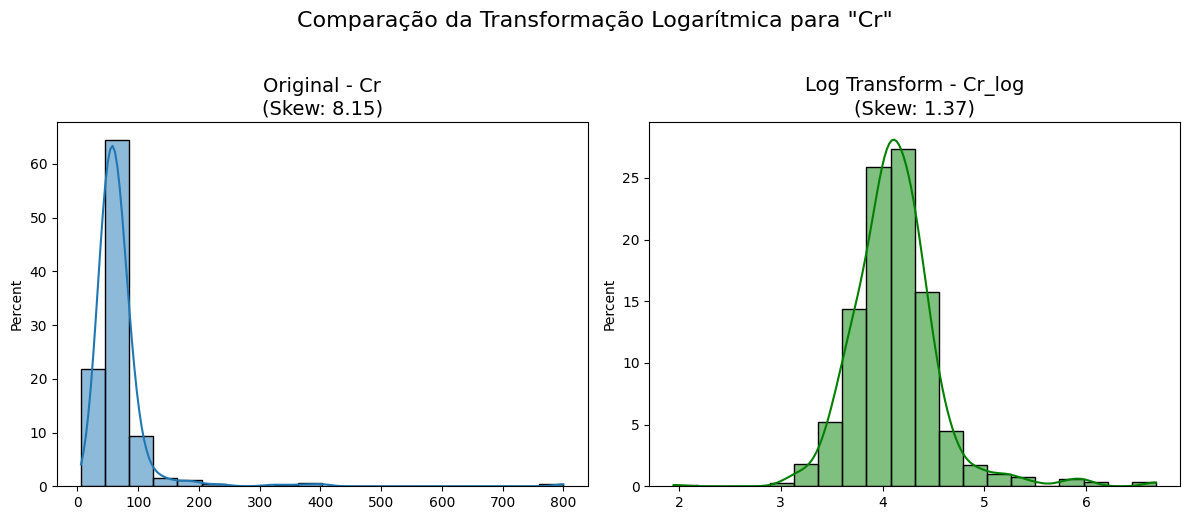

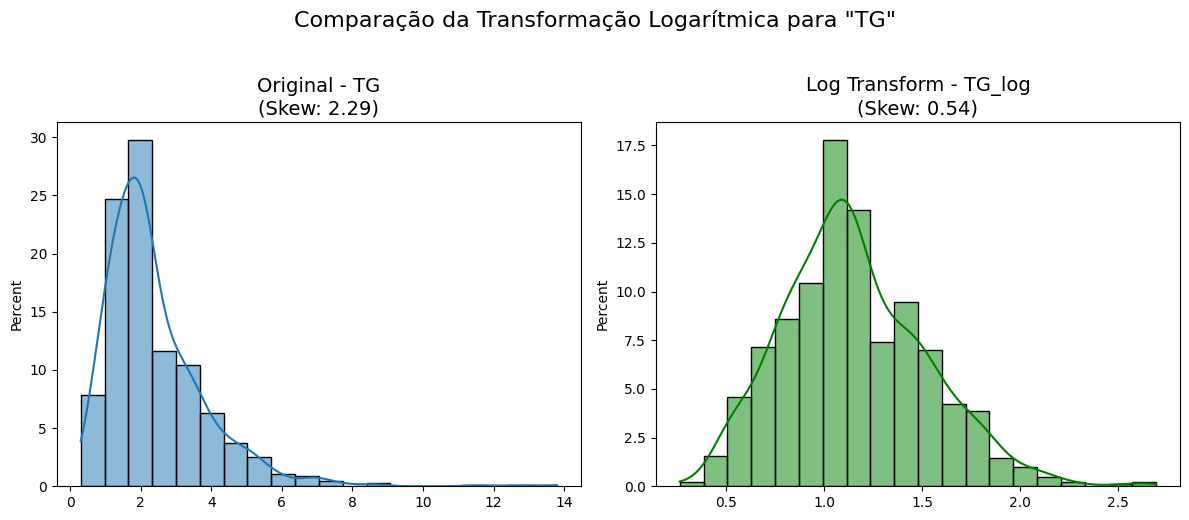

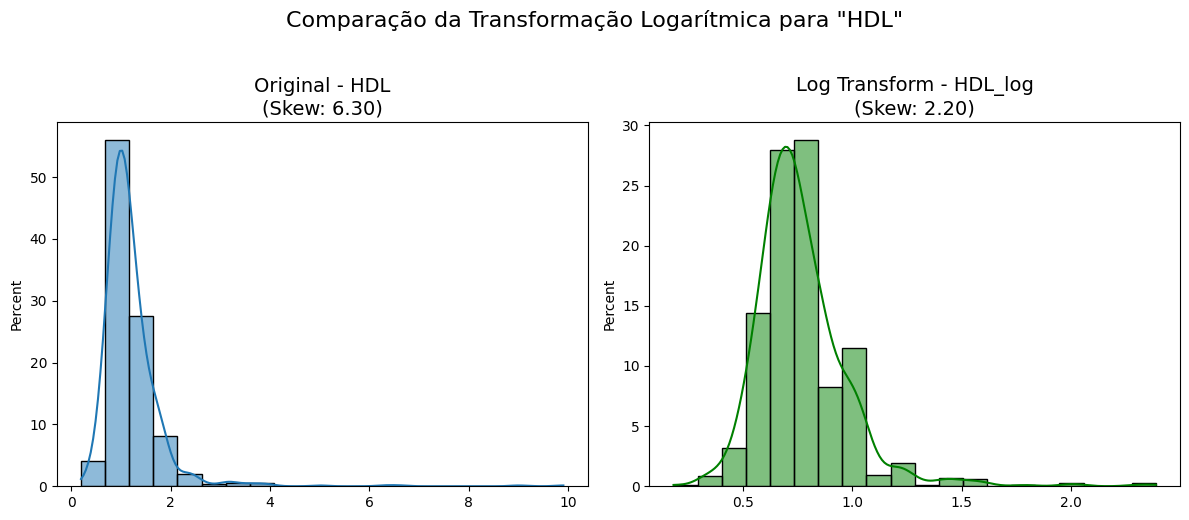

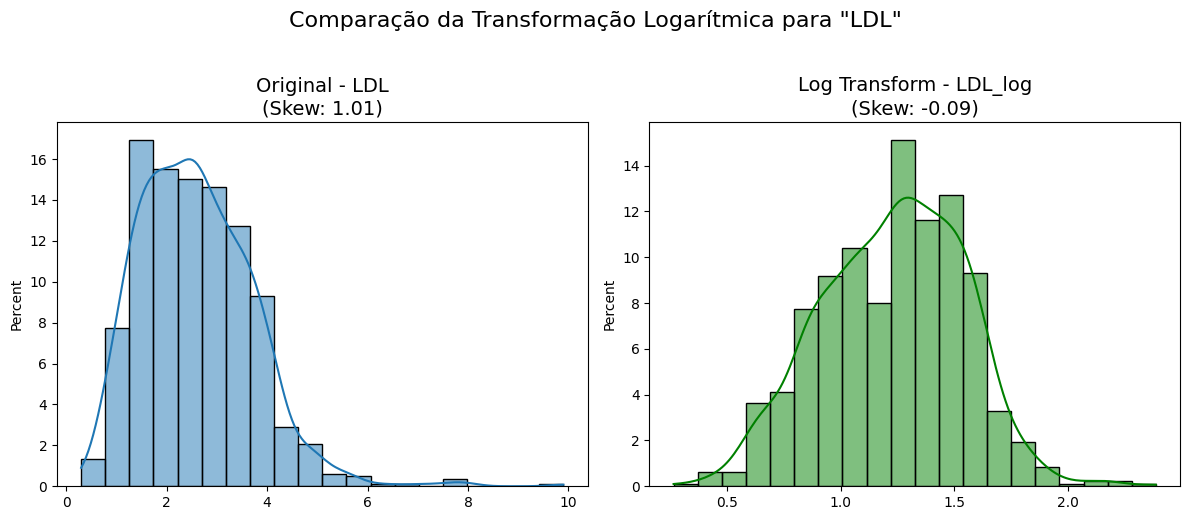

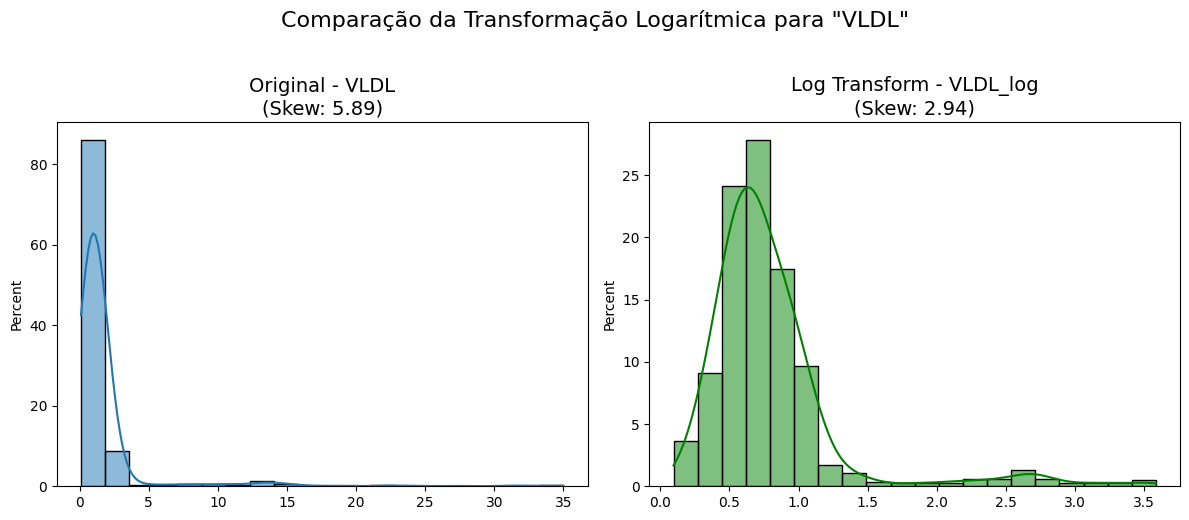

In [ ]:
for col in skew_column_names:
    # Criando a figura e os eixos para o subplot (1 linha, 2 colunas)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Gráfico 1: Distribuição Original ---
    skew_original = df_log[col].skew()
    sns.histplot(df_log[col], kde=True, ax=axes[0], bins=20, stat='percent')
    axes[0].set_title(f'Original - {col}\n(Skew: {skew_original:.2f})', fontsize=14)
    axes[0].set_xlabel('')

    # --- Gráfico 2: Distribuição com Transformação Logarítmica ---
    col_log = col + '_log'
    skew_transformado = df_log[col_log].skew()
    sns.histplot(df_log[col_log], kde=True, ax=axes[1], bins=20, stat='percent', color='green')
    axes[1].set_title(f'Log Transform - {col_log}\n(Skew: {skew_transformado:.2f})', fontsize=14)
    axes[1].set_xlabel('')

    # Título geral
    fig.suptitle(f'Comparação da Transformação Logarítmica para "{col}"', fontsize=16, y=1.03)

    plt.tight_layout()
    plt.show()

## Separação dos dados para modelagem

### selecionando as colunas alvo
***
**Observação:** Aqui vale ressaltar um ponto muito importante que diz respeito à feature HbA1c, isto é, hemoglobina glicada. De acordo com as análises feitas e, posteriormente confirmadas por um profissional da saúde, essa variável sozinha seria capaz de dizer se o paciente é ou não diabético (assim como pré-diabético), pois é um exame diagnóstico. Consequentemente, os modelos iniciais estavam perfomando muito bem, o que era esperado visto que essa variável representava um certo "data leakage". Dessa forma, optamos por remover essa feature do modelo, consequentemente o desempenho diminuiu, porém deixou o problema mais desafiador.
***

In [ ]:
# Identificar colunas que terminam com "_log"
cols_with_log = [col for col in df_log.columns if col.endswith('_log')]

# Obter os nomes originais (sem o sufixo "_log")
original_names_of_transformed = [col.replace('_log', '') for col in cols_with_log]

# Identificar colunas que NÃO foram transformadas (não têm versão "_log")
cols_not_transformed = [col for col in df_log[num_features].columns
                        if not col.endswith('_log') and col not in original_names_of_transformed]

final_columns = cols_not_transformed + cols_with_log + cat_features + ['CLASS']
final_columns.remove('HbA1c') # removendo feature HbA1c

df_log[final_columns].head()

AGE  Chol   BMI  Urea_log    Cr_log    TG_log   HDL_log   LDL_log  \
0   50   4.2  24.0  1.740466  3.850148  0.641854  1.223775  0.875469   
1   26   3.7  23.0  1.704748  4.143135  0.875469  0.741937  1.131402   
2   33   4.9  21.0  2.091864  3.850148  0.693147  0.587787  1.098612   
3   45   2.9  21.0  1.193922  3.218876  0.693147  0.693147  0.916291   
4   50   3.6  24.0  1.098612  3.931826  0.832909  0.641854  1.131402   

   VLDL_log  Gender  CLASS  
0  0.405465       0      1  
1  0.470004       1      1  
2  0.336472       1      1  
3  0.336472       0      1  
4  0.470004       0      1

### Dividindo entre treino, teste e validação

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_log[final_columns].drop(columns=['CLASS']),
    df_log['CLASS'],
    test_size=0.2,
    random_state=42,
    stratify=df_log['CLASS']
)

# Modelagem - Random Forest

## Parâmetros e modelo

In [ ]:
N_SPLITS = 5 # Número de folds para a validação cruzada
RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
rf_params = {
    'n_estimators': 100,
    'criterion': 'log_loss',
    'max_depth': 5,
    'max_features': X_train.shape[1],
    'class_weight': 'balanced',
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

model_rf = RandomForestClassifier(**rf_params)

## Validação cruzada

In [ ]:
results_rf = perform_cross_validation(X_train, y_train, skf, model_rf, average='weighted')


--- Processando Fold 1/5 ---

--- Processando Fold 2/5 ---

--- Processando Fold 3/5 ---

--- Processando Fold 4/5 ---

--- Processando Fold 5/5 ---

Validação Cruzada concluída.


In [ ]:
print("\n--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---")

for metric_name in results_rf['validation']:
    mean_train = np.mean(results_rf['train'][metric_name])
    std_train = np.std(results_rf['train'][metric_name])
    mean_val = np.mean(results_rf['validation'][metric_name])
    std_val = np.std(results_rf['validation'][metric_name])

    print(f"\nMétrica: {metric_name.replace('_', ' ').title()}")
    print(f"  - Treino     : {mean_train:.4f} ± {std_train:.4f}")
    print(f"  - Validação  : {mean_val:.4f} ± {std_val:.4f}")


--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---

Métrica: Accuracy
  - Treino     : 0.9436 ± 0.0111
  - Validação  : 0.8879 ± 0.0088

Métrica: F1 Score
  - Treino     : 0.9475 ± 0.0096
  - Validação  : 0.8958 ± 0.0089

Métrica: Recall
  - Treino     : 0.9436 ± 0.0111
  - Validação  : 0.8879 ± 0.0088

Métrica: Precision
  - Treino     : 0.9576 ± 0.0061
  - Validação  : 0.9119 ± 0.0106

Métrica: Log Loss
  - Treino     : -0.1574 ± 0.0074
  - Validação  : -0.2937 ± 0.1064

Métrica: Roc Auc
  - Treino     : 0.9964 ± 0.0007
  - Validação  : 0.9766 ± 0.0101

Métrica: Pr Auc
  - Treino     : 0.9907 ± 0.0017
  - Validação  : 0.9694 ± 0.0075


## Testando modelo

In [ ]:
feature_names = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

In [ ]:
model_rf = RandomForestClassifier(**rf_params)

print("Treinando o modelo final com os dados de treino completos...")
model_rf.fit(X_train_scaled, y_train) # esse modelo tá pronto pra uso!

print("Avaliando o modelo no conjunto de teste...")
y_pred = model_rf.predict(X_test_scaled)
y_proba = model_rf.predict_proba(X_test_scaled)

Treinando o modelo final com os dados de treino completos...
Avaliando o modelo no conjunto de teste...


## Métricas e visualizações

In [ ]:
test_metrics_rf = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'log_loss': (-1)*log_loss(y_test, y_proba),
    'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
}

for name, value in test_metrics_rf.items():
    print(f"  - {name.replace('_', ' ').title()}: {value:.4f}")

  - Accuracy: 0.9096
  - F1 Score: 0.9130
  - Recall: 0.9096
  - Precision: 0.9266
  - Log Loss: -0.2632
  - Roc Auc: 0.9774


### Scatter plot do logloss

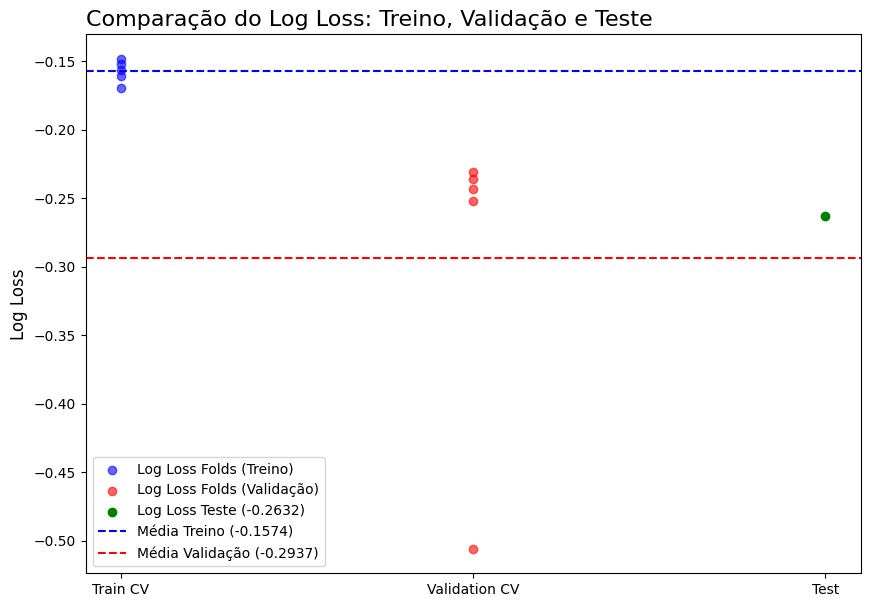

In [ ]:
plt.figure(figsize=(10, 7))

labels = ['Train CV', 'Validation CV', 'Test']
train_losses = results_rf['train']['log_loss']
val_losses = results_rf['validation']['log_loss']
test_loss = test_metrics_rf['log_loss']

plt.scatter(y=train_losses, x=['Train CV']*N_SPLITS, color='blue', alpha=0.6, label='Log Loss Folds (Treino)')
plt.scatter(y=val_losses, x=['Validation CV']*N_SPLITS, color='red', alpha=0.6, label='Log Loss Folds (Validação)')
plt.scatter([2], [test_loss], color='green', label=f'Log Loss Teste ({test_loss:.4f})')

mean_train_loss = np.mean(train_losses)
mean_val_loss = np.mean(val_losses)

plt.axhline(y=mean_train_loss, color='blue', linestyle='--', label=f'Média Treino ({mean_train_loss:.4f})')
plt.axhline(y=mean_val_loss, color='red', linestyle='--', label=f'Média Validação ({mean_val_loss:.4f})')

plt.title('Comparação do Log Loss: Treino, Validação e Teste', fontsize=16, loc='left')
plt.ylabel('Log Loss', fontsize=12)

plt.xticks(range(len(labels)), labels)
#plt.ylim(-0.5, 0)
plt.legend()
plt.grid(False)
plt.show()

### Matriz de confusão

In [ ]:
list(order_by_label)

['Diabético', 'Não-Diabético', 'Pré-Diabético']

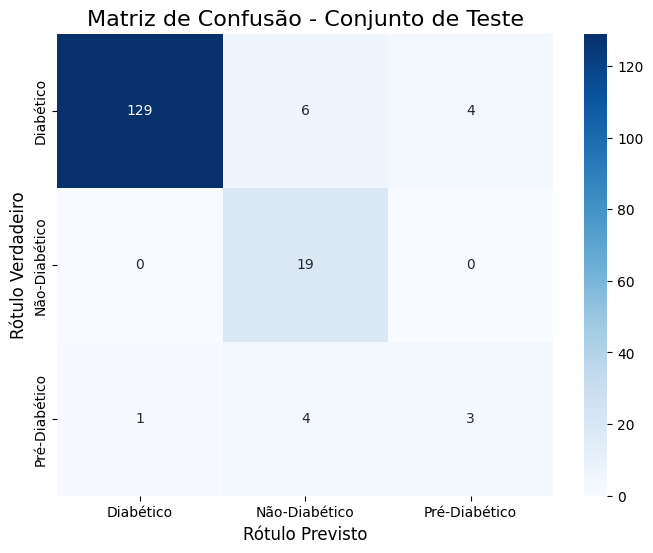

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(order_by_label), yticklabels=list(order_by_label))
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16)
plt.xlabel('Rótulo Previsto', fontsize=12)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=[str(c) for c in list(order_by_label)], digits=4))


               precision    recall  f1-score   support

    Diabético     0.9923    0.9281    0.9591       139
Não-Diabético     0.6552    1.0000    0.7917        19
Pré-Diabético     0.4286    0.3750    0.4000         8

     accuracy                         0.9096       166
    macro avg     0.6920    0.7677    0.7169       166
 weighted avg     0.9266    0.9096    0.9130       166



### Feature importance

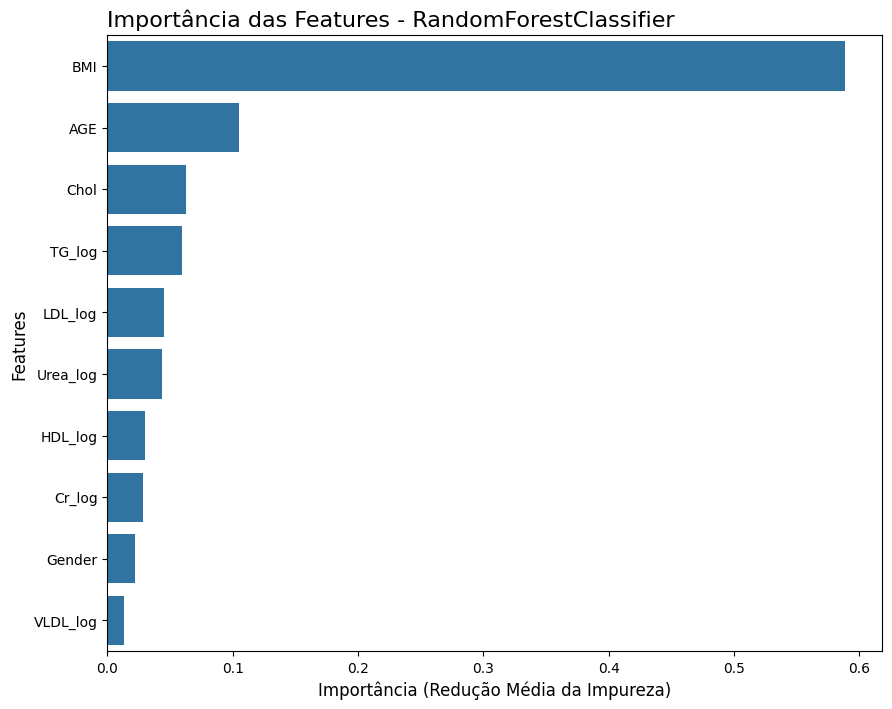

In [ ]:
importances = model_rf.feature_importances_
feature_names = X_train.columns
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_series, y=feature_importance_series.index)
plt.title('Importância das Features - RandomForestClassifier', fontsize=16, loc='left')
plt.xlabel('Importância (Redução Média da Impureza)', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.show()

### SHAP Values

In [ ]:
explainer = shap.TreeExplainer(model_rf)

shap_values = explainer.shap_values(X_test_df)

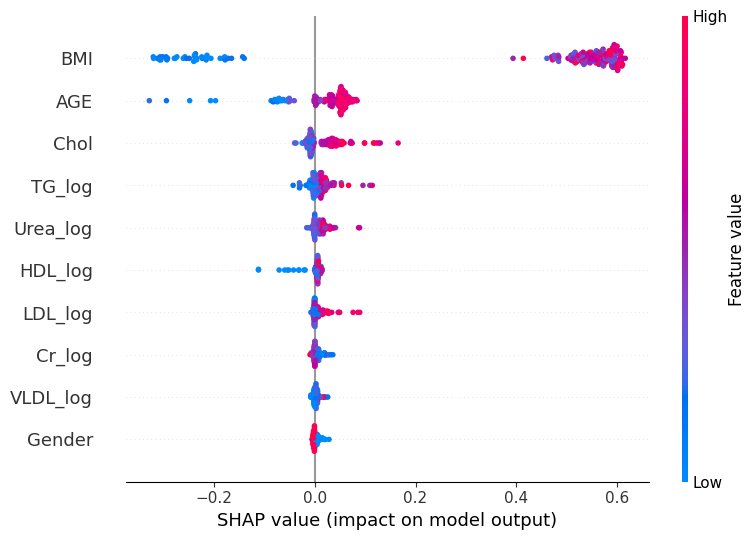

In [ ]:
shap.summary_plot(shap_values[:,:,0], X_test_df)
plt.show()

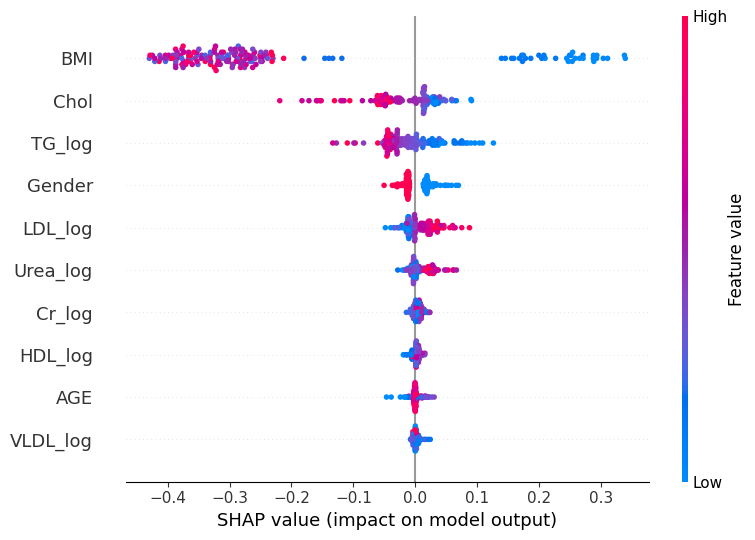

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test_df)
plt.show()

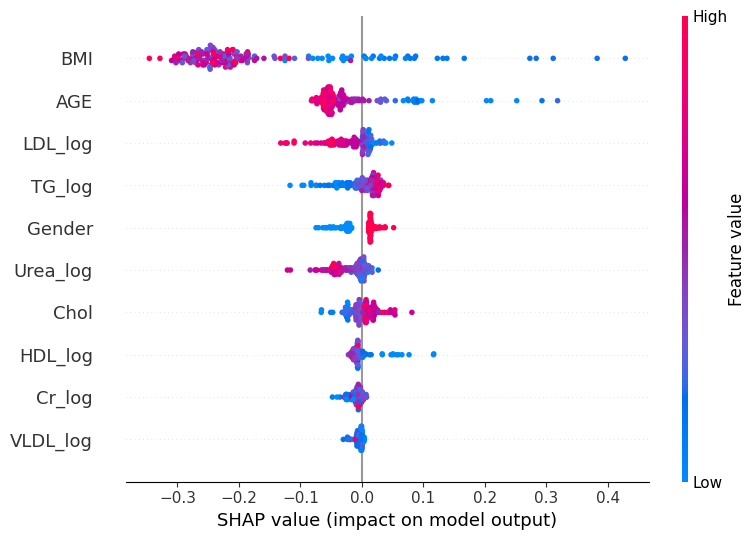

In [ ]:
shap.summary_plot(shap_values[:,:,2], X_test_df)
plt.show()

# Modelagem - Decision Tree

## Parâmetros e modelo

In [ ]:
dt_params = {
    'criterion': 'log_loss',
    'max_depth': 3,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': X_train.shape[1],
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE
}

model_dt = DecisionTreeClassifier(**dt_params)

## Validação cruzada

In [ ]:
results_dt = perform_cross_validation(X_train, y_train, skf, model_dt, average='weighted')


--- Processando Fold 1/5 ---

--- Processando Fold 2/5 ---

--- Processando Fold 3/5 ---

--- Processando Fold 4/5 ---

--- Processando Fold 5/5 ---

Validação Cruzada concluída.


In [ ]:
print("\n--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---")

for metric_name in results_dt['validation']:
    mean_train = np.mean(results_dt['train'][metric_name])
    std_train = np.std(results_dt['train'][metric_name])
    mean_val = np.mean(results_dt['validation'][metric_name])
    std_val = np.std(results_dt['validation'][metric_name])

    print(f"\nMétrica: {metric_name.replace('_', ' ').title()}")
    print(f"  - Treino     : {mean_train:.4f} ± {std_train:.4f}")
    print(f"  - Validação  : {mean_val:.4f} ± {std_val:.4f}")


--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---

Métrica: Accuracy
  - Treino     : 0.8739 ± 0.0177
  - Validação  : 0.8379 ± 0.0228

Métrica: F1 Score
  - Treino     : 0.8921 ± 0.0151
  - Validação  : 0.8648 ± 0.0141

Métrica: Recall
  - Treino     : 0.8739 ± 0.0177
  - Validação  : 0.8379 ± 0.0228

Métrica: Precision
  - Treino     : 0.9263 ± 0.0098
  - Validação  : 0.9035 ± 0.0123

Métrica: Log Loss
  - Treino     : -0.2995 ± 0.0259
  - Validação  : -0.5856 ± 0.2095

Métrica: Roc Auc
  - Treino     : 0.9742 ± 0.0069
  - Validação  : 0.9467 ± 0.0190

Métrica: Pr Auc
  - Treino     : 0.9625 ± 0.0043
  - Validação  : 0.9410 ± 0.0137


## Testando modelo

In [ ]:
model_dt = DecisionTreeClassifier(**dt_params)

print("Treinando o modelo final com os dados de treino completos...")
model_dt.fit(X_train_scaled, y_train) # esse modelo tá pronto pra uso!

print("Avaliando o modelo no conjunto de teste...")
y_pred = model_dt.predict(X_test_scaled)
y_proba = model_dt.predict_proba(X_test_scaled)

Treinando o modelo final com os dados de treino completos...
Avaliando o modelo no conjunto de teste...


## Métricas e visualizações

In [ ]:
test_metrics_dt = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'log_loss': (-1)*log_loss(y_test, y_proba),
    'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
}

for name, value in test_metrics_dt.items():
    print(f"  - {name.replace('_', ' ').title()}: {value:.4f}")

  - Accuracy: 0.8795
  - F1 Score: 0.8923
  - Recall: 0.8795
  - Precision: 0.9149
  - Log Loss: -0.5836
  - Roc Auc: 0.9468


### Scater plot do logloss

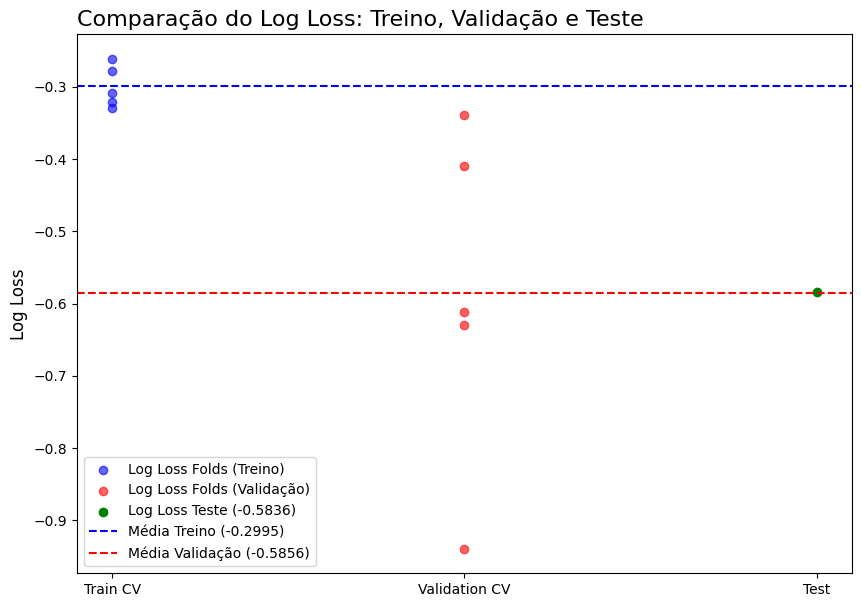

In [ ]:
plt.figure(figsize=(10, 7))

labels = ['Train CV', 'Validation CV', 'Test']
train_losses = results_dt['train']['log_loss']
val_losses = results_dt['validation']['log_loss']
test_loss = test_metrics_dt['log_loss']

plt.scatter(y=train_losses, x=['Train CV']*N_SPLITS, color='blue', alpha=0.6, label='Log Loss Folds (Treino)')
plt.scatter(y=val_losses, x=['Validation CV']*N_SPLITS, color='red', alpha=0.6, label='Log Loss Folds (Validação)')
plt.scatter([2], [test_loss], color='green', label=f'Log Loss Teste ({test_loss:.4f})')

mean_train_loss = np.mean(train_losses)
mean_val_loss = np.mean(val_losses)

plt.axhline(y=mean_train_loss, color='blue', linestyle='--', label=f'Média Treino ({mean_train_loss:.4f})')
plt.axhline(y=mean_val_loss, color='red', linestyle='--', label=f'Média Validação ({mean_val_loss:.4f})')

plt.title('Comparação do Log Loss: Treino, Validação e Teste', fontsize=16, loc='left')
plt.ylabel('Log Loss', fontsize=12)

plt.xticks(range(len(labels)), labels)
#plt.ylim(-0.5, 0)
plt.legend()
plt.grid(False)
plt.show()

### Matriz de confusão

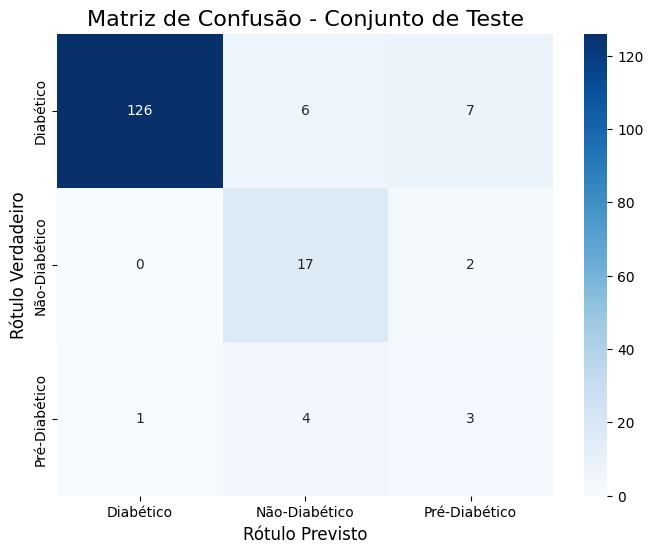

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(order_by_label), yticklabels=list(order_by_label))
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16)
plt.xlabel('Rótulo Previsto', fontsize=12)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=[str(c) for c in list(order_by_label)], digits=4))


               precision    recall  f1-score   support

    Diabético     0.9921    0.9065    0.9474       139
Não-Diabético     0.6296    0.8947    0.7391        19
Pré-Diabético     0.2500    0.3750    0.3000         8

     accuracy                         0.8795       166
    macro avg     0.6239    0.7254    0.6622       166
 weighted avg     0.9149    0.8795    0.8923       166



### Feature importance

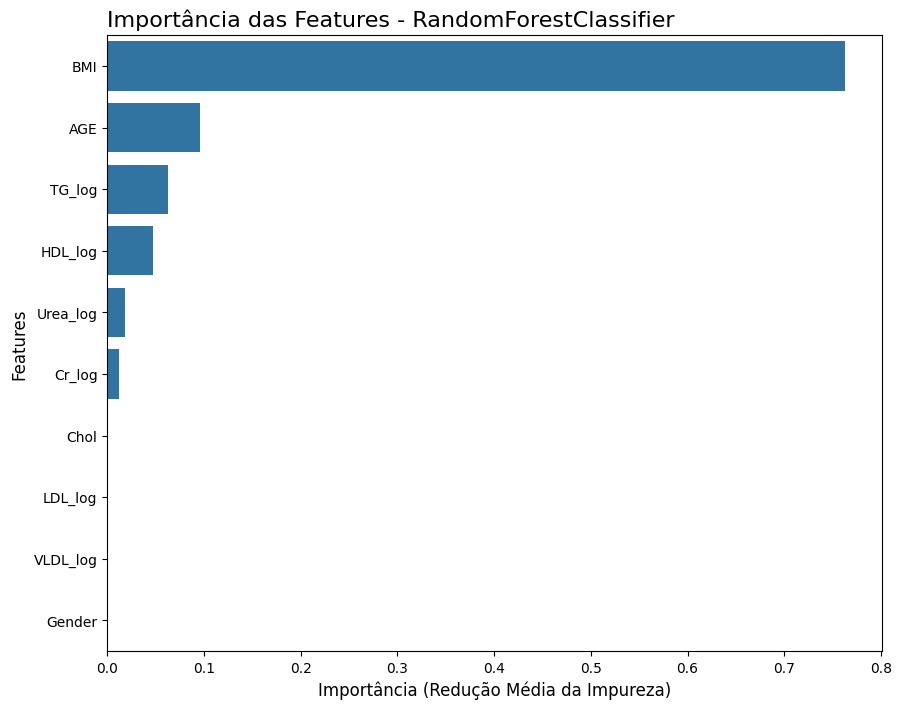

In [ ]:
importances = model_dt.feature_importances_
feature_names = X_train.columns
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_series, y=feature_importance_series.index)
plt.title('Importância das Features - RandomForestClassifier', fontsize=16, loc='left')
plt.xlabel('Importância (Redução Média da Impureza)', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.show()

### SHAP Values

In [ ]:
explainer = shap.TreeExplainer(model_dt)

shap_values = explainer.shap_values(X_test_df)

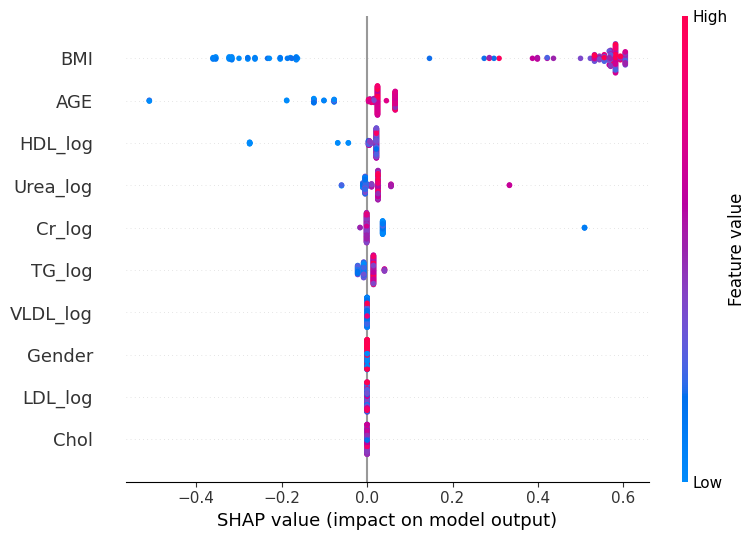

In [ ]:
shap.summary_plot(shap_values[:,:,0], X_test_df)
plt.show()

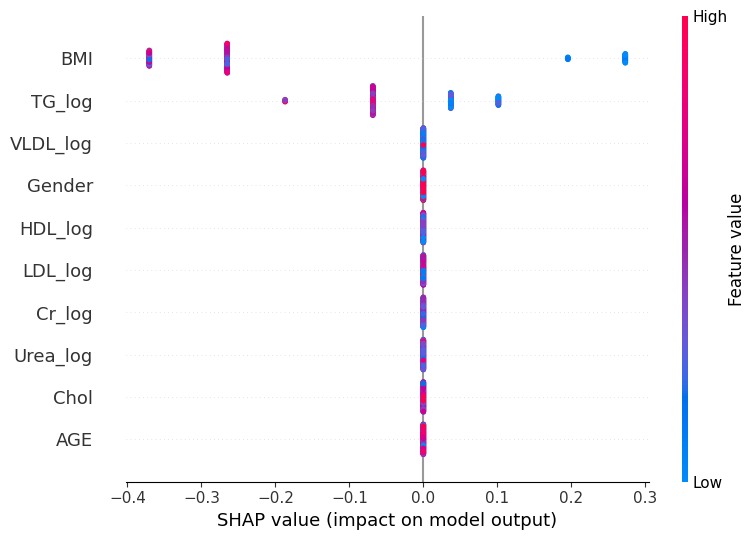

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test_df)
plt.show()

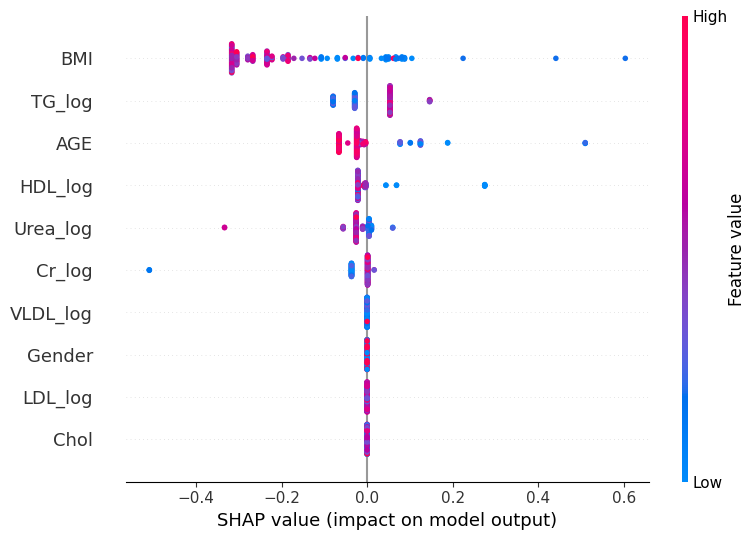

In [ ]:
shap.summary_plot(shap_values[:,:,2], X_test_df)
plt.show()

# Modelagem - XGBoost

## Parâmetros e modelo

In [ ]:
xgb_params = {
    'objective': 'multi:softprob',  # Define o problema como classificação multiclasse e retorna probabilidades.
    'n_estimators': 150,            # Um número razoável de árvores para começar.
    'learning_rate': 0.05,           # Taxa de aprendizado. Um valor mais baixo torna o modelo mais robusto.
    'max_depth': 7,                 # Profundidade máxima das árvores. Essencial para evitar overfitting em dados pequenos.
    'subsample': 0.9,               # Usa 80% das amostras para treinar cada árvore, previne overfitting.
    'colsample_bytree': 0.7,        # Usa 80% das features para treinar cada árvore, previne overfitting.
    'eval_metric': 'mlogloss',      # Métrica de avaliação a ser usada (multiclass logloss).
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

xgb_model = XGBClassifier(**xgb_params)

## Validação cruzada

In [ ]:
results_xgb = perform_cross_validation(X_train, y_train, skf, xgb_model, average='weighted')


--- Processando Fold 1/5 ---

--- Processando Fold 2/5 ---

--- Processando Fold 3/5 ---

--- Processando Fold 4/5 ---

--- Processando Fold 5/5 ---

Validação Cruzada concluída.


In [ ]:
print("\n--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---")

for metric_name in results_xgb['validation']:
    mean_train = np.mean(results_xgb['train'][metric_name])
    std_train = np.std(results_xgb['train'][metric_name])
    mean_val = np.mean(results_xgb['validation'][metric_name])
    std_val = np.std(results_xgb['validation'][metric_name])

    print(f"\nMétrica: {metric_name.replace('_', ' ').title()}")
    print(f"  - Treino     : {mean_train:.4f} ± {std_train:.4f}")
    print(f"  - Validação  : {mean_val:.4f} ± {std_val:.4f}")


--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---

Métrica: Accuracy
  - Treino     : 0.9985 ± 0.0008
  - Validação  : 0.9409 ± 0.0111

Métrica: F1 Score
  - Treino     : 0.9985 ± 0.0008
  - Validação  : 0.9317 ± 0.0147

Métrica: Recall
  - Treino     : 0.9985 ± 0.0008
  - Validação  : 0.9409 ± 0.0111

Métrica: Precision
  - Treino     : 0.9985 ± 0.0007
  - Validação  : 0.9331 ± 0.0227

Métrica: Log Loss
  - Treino     : -0.0227 ± 0.0021
  - Validação  : -0.1843 ± 0.0364

Métrica: Roc Auc
  - Treino     : 1.0000 ± 0.0000
  - Validação  : 0.9832 ± 0.0113

Métrica: Pr Auc
  - Treino     : 1.0000 ± 0.0000
  - Validação  : 0.9840 ± 0.0064


## Testando modelo

In [ ]:
xgb_model = XGBClassifier(**xgb_params)

print("Treinando o modelo final com os dados de treino completos...")
xgb_model.fit(X_train_scaled, y_train) # esse modelo tá pronto pra uso!

print("Avaliando o modelo no conjunto de teste...")
y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)

Treinando o modelo final com os dados de treino completos...
Avaliando o modelo no conjunto de teste...


## Métricas e visualizações

In [ ]:
test_metrics_xgb = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'log_loss': (-1)*log_loss(y_test, y_proba),
    'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
}

for name, value in test_metrics_xgb.items():
    print(f"  - {name.replace('_', ' ').title()}: {value:.4f}")

  - Accuracy: 0.9398
  - F1 Score: 0.9355
  - Recall: 0.9398
  - Precision: 0.9390
  - Log Loss: -0.1892
  - Roc Auc: 0.9790


### Scatter plot do logloss

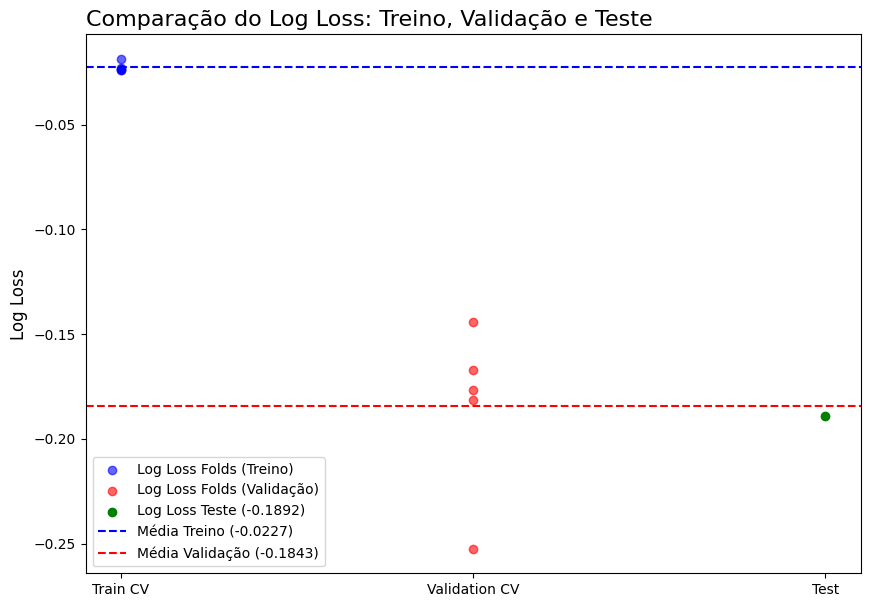

In [ ]:
plt.figure(figsize=(10, 7))

labels = ['Train CV', 'Validation CV', 'Test']
train_losses = results_xgb['train']['log_loss']
val_losses = results_xgb['validation']['log_loss']
test_loss = test_metrics_xgb['log_loss']

plt.scatter(y=train_losses, x=['Train CV']*N_SPLITS, color='blue', alpha=0.6, label='Log Loss Folds (Treino)')
plt.scatter(y=val_losses, x=['Validation CV']*N_SPLITS, color='red', alpha=0.6, label='Log Loss Folds (Validação)')
plt.scatter([2], [test_loss], color='green', label=f'Log Loss Teste ({test_loss:.4f})')

mean_train_loss = np.mean(train_losses)
mean_val_loss = np.mean(val_losses)

plt.axhline(y=mean_train_loss, color='blue', linestyle='--', label=f'Média Treino ({mean_train_loss:.4f})')
plt.axhline(y=mean_val_loss, color='red', linestyle='--', label=f'Média Validação ({mean_val_loss:.4f})')

plt.title('Comparação do Log Loss: Treino, Validação e Teste', fontsize=16, loc='left')
plt.ylabel('Log Loss', fontsize=12)

plt.xticks(range(len(labels)), labels)
#plt.ylim(-0.5, 0)
plt.legend()
plt.grid(False)
plt.show()

### Matriz de confusão

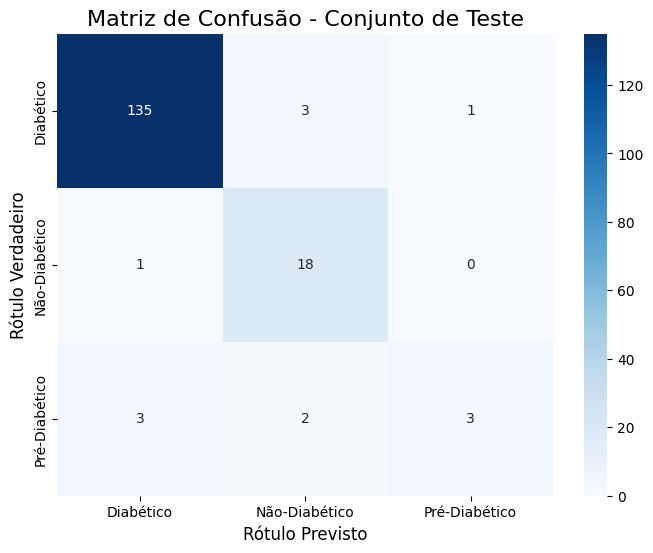

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(order_by_label), yticklabels=list(order_by_label))
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16)
plt.xlabel('Rótulo Previsto', fontsize=12)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=[str(c) for c in list(order_by_label)], digits=4))


               precision    recall  f1-score   support

    Diabético     0.9712    0.9712    0.9712       139
Não-Diabético     0.7826    0.9474    0.8571        19
Pré-Diabético     0.7500    0.3750    0.5000         8

     accuracy                         0.9398       166
    macro avg     0.8346    0.7645    0.7761       166
 weighted avg     0.9390    0.9398    0.9355       166



### Feature importance

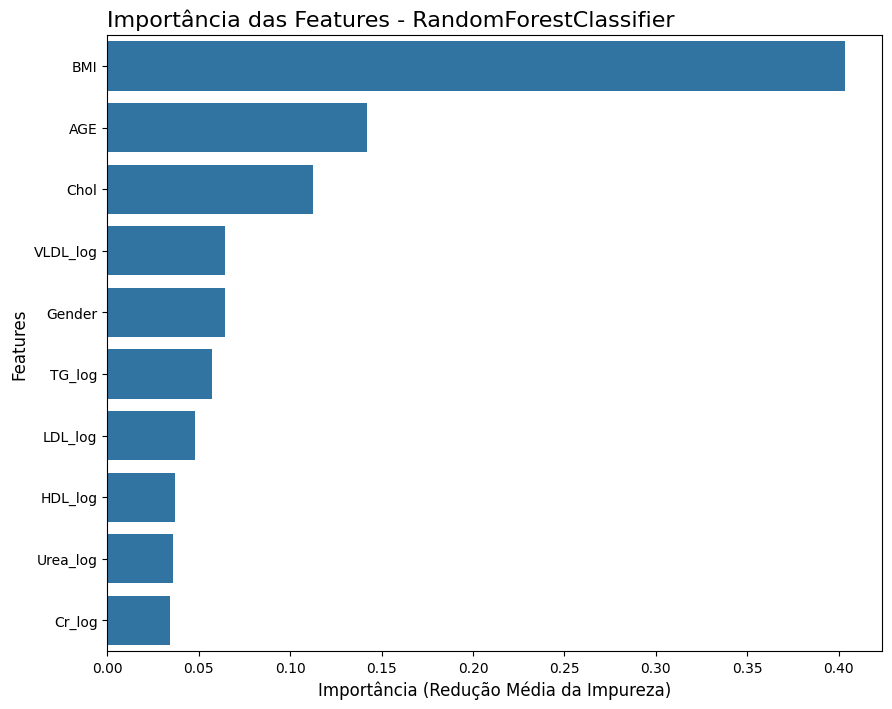

In [ ]:
importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_series, y=feature_importance_series.index)
plt.title('Importância das Features - RandomForestClassifier', fontsize=16, loc='left')
plt.xlabel('Importância (Redução Média da Impureza)', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.show()

### SHAP Values

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_df)

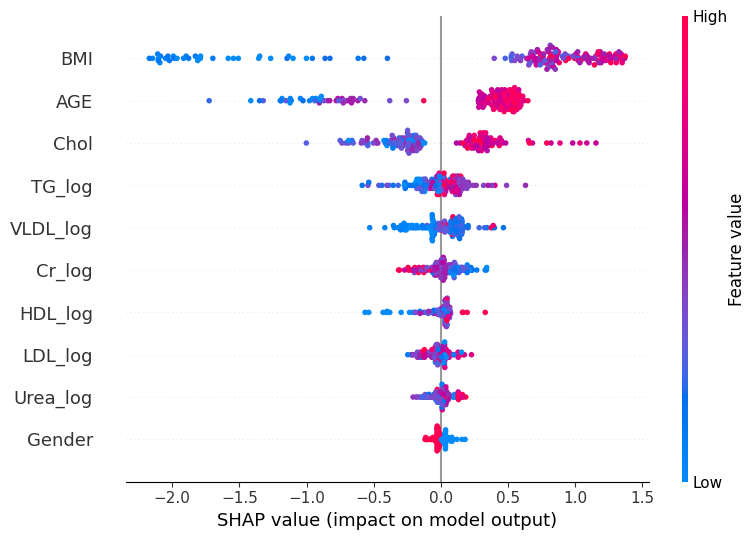

In [ ]:
shap.summary_plot(shap_values[:,:,0], X_test_df)
plt.show()

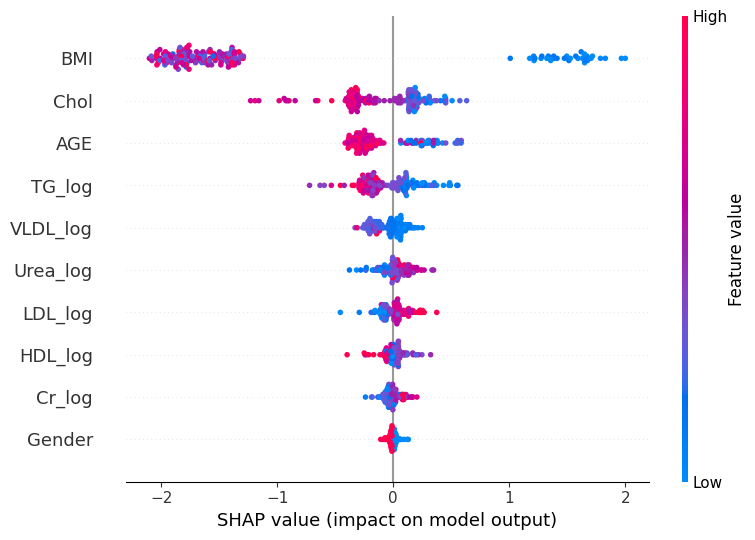

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test_df)
plt.show()

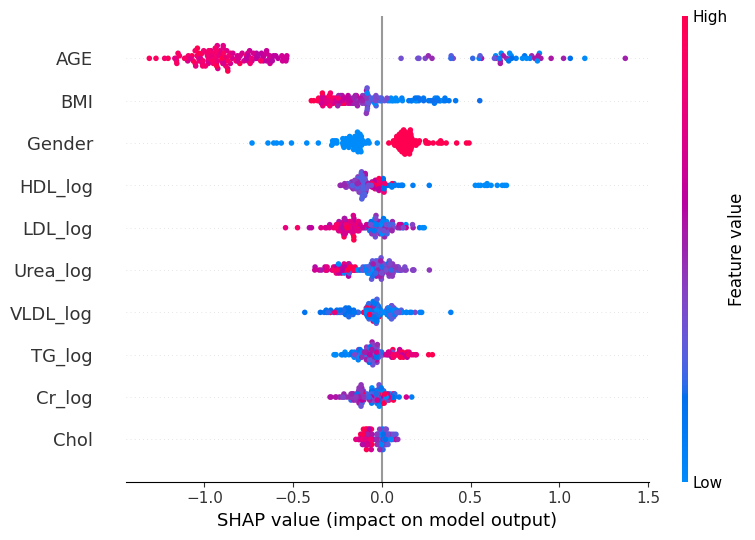

In [ ]:
shap.summary_plot(shap_values[:,:,2], X_test_df)
plt.show()

# Modelagem - LightGBM

## Parâmetros e modelo

In [ ]:
# Dicionário de parâmetros iniciais para LightGBM
RANDOM_STATE = 42

lgbm_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'n_estimators': 150,
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': -1,
}

lgbm_model = LGBMClassifier(**lgbm_params)

## Validação cruzada

In [ ]:
results_lgb = perform_cross_validation(X_train, y_train, skf, lgbm_model, average='weighted')


--- Processando Fold 1/5 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Processando Fold 2/5 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Processando Fold 3/5 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Processando Fold 4/5 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Processando Fold 5/5 ---

Validação Cruzada concluída.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
print("\n--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---")

for metric_name in results_lgb['validation']:
    mean_train = np.mean(results_lgb['train'][metric_name])
    std_train = np.std(results_lgb['train'][metric_name])
    mean_val = np.mean(results_lgb['validation'][metric_name])
    std_val = np.std(results_lgb['validation'][metric_name])

    print(f"\nMétrica: {metric_name.replace('_', ' ').title()}")
    print(f"  - Treino     : {mean_train:.4f} ± {std_train:.4f}")
    print(f"  - Validação  : {mean_val:.4f} ± {std_val:.4f}")


--- Resultados Finais da Validação Cruzada (Média ± Desvio Padrão) ---

Métrica: Accuracy
  - Treino     : 0.9981 ± 0.0012
  - Validação  : 0.9212 ± 0.0132

Métrica: F1 Score
  - Treino     : 0.9981 ± 0.0012
  - Validação  : 0.9179 ± 0.0137

Métrica: Recall
  - Treino     : 0.9981 ± 0.0012
  - Validação  : 0.9212 ± 0.0132

Métrica: Precision
  - Treino     : 0.9982 ± 0.0012
  - Validação  : 0.9165 ± 0.0173

Métrica: Log Loss
  - Treino     : -0.0206 ± 0.0020
  - Validação  : -0.2244 ± 0.0349

Métrica: Roc Auc
  - Treino     : 1.0000 ± 0.0000
  - Validação  : 0.9853 ± 0.0052

Métrica: Pr Auc
  - Treino     : 1.0000 ± 0.0000
  - Validação  : 0.9801 ± 0.0046


## Testando modelo

In [ ]:
lgbm_model = LGBMClassifier(**lgbm_params)

print("Treinando o modelo final com os dados de treino completos...")
lgbm_model.fit(X_train_scaled, y_train) # esse modelo tá pronto pra uso!

print("Avaliando o modelo no conjunto de teste...")
y_pred = lgbm_model.predict(X_test_scaled)
y_proba = lgbm_model.predict_proba(X_test_scaled)

Treinando o modelo final com os dados de treino completos...
Avaliando o modelo no conjunto de teste...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Métricas e visualizações

In [ ]:
test_metrics_lgb = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'log_loss': (-1)*log_loss(y_test, y_proba),
    'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
}

for name, value in test_metrics_lgb.items():
    print(f"  - {name.replace('_', ' ').title()}: {value:.4f}")

  - Accuracy: 0.9217
  - F1 Score: 0.9238
  - Recall: 0.9217
  - Precision: 0.9315
  - Log Loss: -0.2528
  - Roc Auc: 0.9744


### Scatter plot do logloss

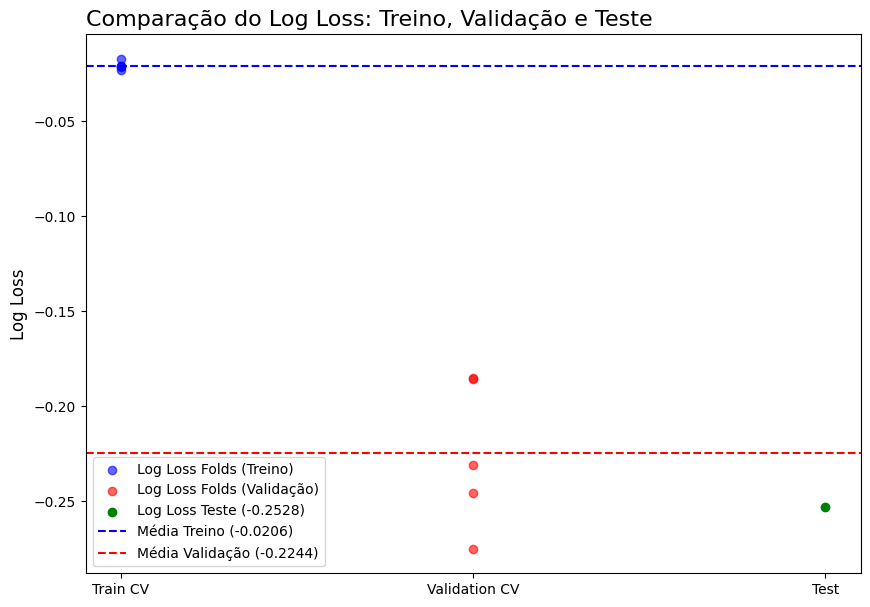

In [ ]:
plt.figure(figsize=(10, 7))

labels = ['Train CV', 'Validation CV', 'Test']
train_losses = results_lgb['train']['log_loss']
val_losses = results_lgb['validation']['log_loss']
test_loss = test_metrics_lgb['log_loss']

plt.scatter(y=train_losses, x=['Train CV']*N_SPLITS, color='blue', alpha=0.6, label='Log Loss Folds (Treino)')
plt.scatter(y=val_losses, x=['Validation CV']*N_SPLITS, color='red', alpha=0.6, label='Log Loss Folds (Validação)')
plt.scatter([2], [test_loss], color='green', label=f'Log Loss Teste ({test_loss:.4f})')

mean_train_loss = np.mean(train_losses)
mean_val_loss = np.mean(val_losses)

plt.axhline(y=mean_train_loss, color='blue', linestyle='--', label=f'Média Treino ({mean_train_loss:.4f})')
plt.axhline(y=mean_val_loss, color='red', linestyle='--', label=f'Média Validação ({mean_val_loss:.4f})')

plt.title('Comparação do Log Loss: Treino, Validação e Teste', fontsize=16, loc='left')
plt.ylabel('Log Loss', fontsize=12)

plt.xticks(range(len(labels)), labels)
#plt.ylim(-0.5, 0)
plt.legend()
plt.grid(False)
plt.show()

### Matriz de confusão

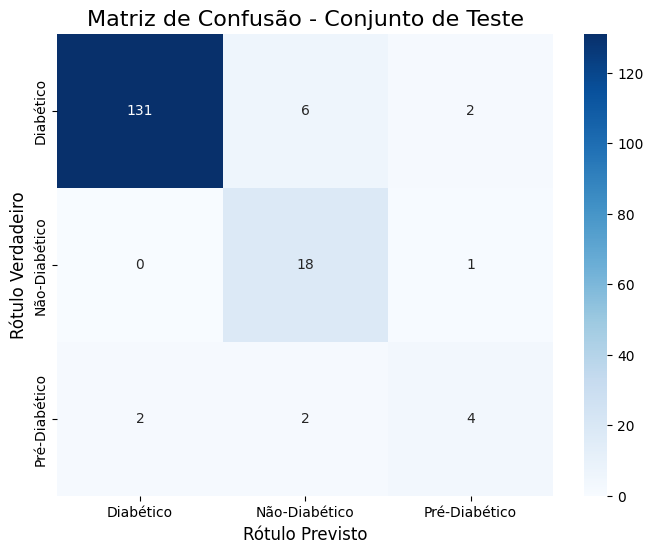

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(order_by_label), yticklabels=list(order_by_label))
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=16)
plt.xlabel('Rótulo Previsto', fontsize=12)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=[str(c) for c in list(order_by_label)], digits=4))


               precision    recall  f1-score   support

    Diabético     0.9850    0.9424    0.9632       139
Não-Diabético     0.6923    0.9474    0.8000        19
Pré-Diabético     0.5714    0.5000    0.5333         8

     accuracy                         0.9217       166
    macro avg     0.7496    0.7966    0.7655       166
 weighted avg     0.9315    0.9217    0.9238       166



### Feature importance

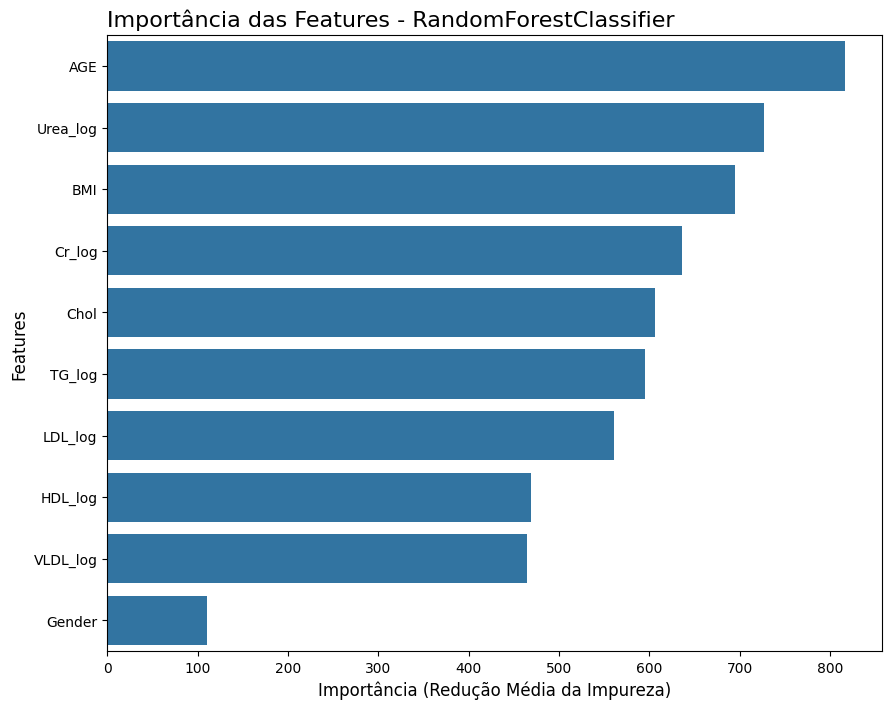

In [ ]:
importances = lgbm_model.feature_importances_
feature_names = X_train.columns
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_series, y=feature_importance_series.index)
plt.title('Importância das Features - RandomForestClassifier', fontsize=16, loc='left')
plt.xlabel('Importância (Redução Média da Impureza)', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.show()

### SHAP Values

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

shap_values = explainer.shap_values(X_test_df)

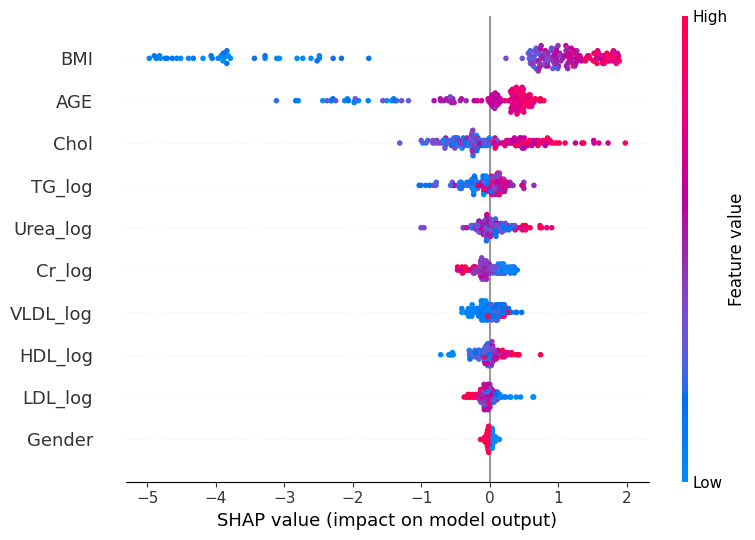

In [ ]:
shap.summary_plot(shap_values[:,:,0], X_test_df)
plt.show()

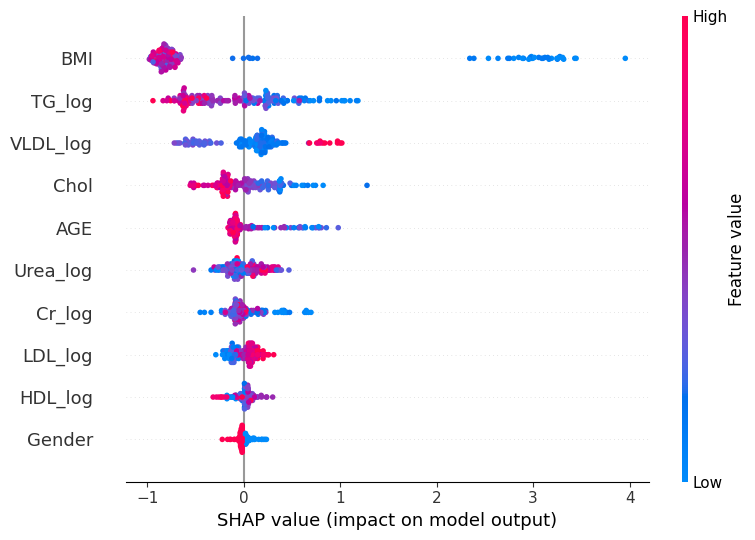

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_test_df)
plt.show()

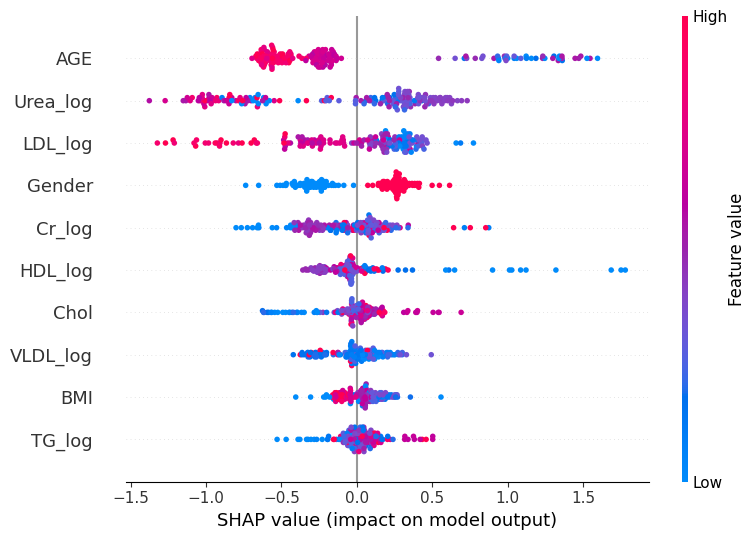

In [ ]:
shap.summary_plot(shap_values[:,:,2], X_test_df)
plt.show()